# Weather dataset

This is a weather dataset from Australia. The dataset contains records from various territories and also has various attributes, thanks to which it is possible to create interesting hypotheses and predictions.

Link to data https://www.kaggle.com/jsphyg/weather-dataset-rattle-package, in dataset is added one column - Territory, to create more analysis.

## Content:
* [Load the dataset](#first)
* [Analysis of categorical attributes](#second)
* [Analysis of continuous attributes](#third)
* [Dataframe modification](#fourth)
* [Correlation](#fifth)
* [Pair analysis of attributes](#sixth)
* [Hypotheses](#seventh)
* [Prediction](#eigth)
* [Bayes](#nineth)


In [1]:
import csv
import pandas as pd
import numpy as np 
from scipy import stats
import statistics
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

Functions

In [2]:
def calculate_stats(column):

    print("Number of nan values")
    print(column.isna().sum())
    
    print("------------------------")
    
    print("Max\t\tMin\t\tAverage\t\tMedian")
    print(column.max(), "\t\t", column.min(), "\t\t",round(np.mean(column), 2), "\t\t", round(np.nanmedian(column), 2))
    
    print("------------------------------------------------")
    
    print("Variance\tStandard deviation\t\tRange of variation\t\tAverage absolute deviation")
    print(round(np.var(column), 2), "\t\t",round(np.std(column), 2), "\t\t\t\t",round(column.max() - column.min(), 2), "\t\t\t\t", round(np.mean(np.absolute(column - np.mean(column))),2))
    
    print("------------------------------------------------")
    
    Q1 = np.nanquantile(column, 0.25)
    Q3 = np.nanquantile(column, 0.75)
    print("Lower quartile, 25%\t\t\tUpper quartile, 75%\t\t\tInterquartile range")
    print(round(Q1, 1), "\t\t\t\t\t",round(Q3, 1), "\t\t\t\t\t", round(Q3-Q1, 2))
    print("\nNumber of skewed lower outliers\t\tNumber of skewed upper outliers\t\tInterquartile deviation")
    print(sum(column < (Q1 - 1.5 * (Q3-Q1))), "\t\t\t\t\t", sum(column > (Q3 + 1.5 * (Q3-Q1))),"\t\t\t\t\t",round((Q3-Q1)*0.5, 2))
    print("\nNumber of extreme lower outliers\tNumber of extreme upper outliers")
    print(sum(column < (Q1 - 3 * (Q3-Q1))), "\t\t\t\t\t", sum(column > (Q3 + 3 * (Q3-Q1))))
    
    print("------------------------------------------------")
    
    print("Skewness\t\t\t\tKurtosis")
    df_minTemp = column.dropna()
    print(stats.skew(df_minTemp), "\t\t",stats.kurtosis(df_minTemp))

In [3]:
def createGraphs(column):
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,15))
    
    #qq
    sm.qqplot(column, line = "45", ax=axes[0,0])

    #boxplot
    sns.boxplot(data=column, ax=axes[0,1])

    #histogram
    column.plot.hist(grid=True, bins=50, rwidth=0.9, color='pink',orientation='horizontal', ax=axes[0,2])
    plt.grid(axis='y', alpha=0.75)

    #density
    sns.set(style="darkgrid")
    sns.kdeplot(column, shade=True, ax=axes[1,0])

    #pp
    norm = np.random.normal(0, 1, len(column))
    norm = norm - (min(norm) - min(column))
    min_value = min(norm)
    scale = (max(column) - min_value) / (max(norm) - min_value)
    norm = np.apply_along_axis(lambda x : min_value + (x-min_value)*scale, axis=0, arr=norm)
    var = column.to_numpy()
    norm.sort()
    var.sort()
    bins = np.percentile(norm, np.linspace(0, 100, 1000))
    data_hist, _ = np.histogram(var, bins=bins)
    cumsum_data = np.cumsum(data_hist)
    cumsum_data = np.array(cumsum_data) / max(cumsum_data)
    norm_hist, _  = np.histogram(norm, bins=bins)
    cumsum_norm = np.cumsum(norm_hist)
    cumsum_norm = np.array(cumsum_norm) / max(cumsum_norm)
    axes[1,1].plot(cumsum_norm, cumsum_data, 'o')
    axes[1,1].plot([0, 1], [0, 1], color='r')
       
    plt.show()

In [4]:
def dateRange(data):
    for i in data['Territory'].unique():
        if type(i) == str:
            df = data.loc[data['Territory'] == i]
            print(i)
            print(df['Date'].min(), "\t", df['Date'].max())

In [5]:
def locGraph(data):
    tmp_val = []
    tmp_name = []
    for i in data['Location'].unique():
        if type(i) == str:
            df = data.loc[data['Location'] == i]
            tmp_val.append(len(df.axes[0]))
            tmp_name.append(i)

    x_pos = np.arange(len(data['Location'].unique()))
    plt.figure(figsize=(15,15))
    plt.bar(x_pos, tmp_val)
    plt.xlabel('Meteorological Stations')
    plt.ylabel('Number of records')
    plt.xticks(x_pos, tmp_name, rotation='vertical')
    plt.show()

In [6]:
def territoryGraph(data):
    plt.figure(figsize=(10,10))
    ax = sns.countplot(y="Territory", data=data)

    plt.title('Number of records from individual territories')
    plt.xlabel('Quantity')

    total = len(data['Territory'])
    for p in ax.patches:
            percentage = '{:.1f}%'.format(100 * p.get_width()/total)
            x = p.get_x() + p.get_width() + 0.02
            y = p.get_y() + p.get_height()/2
            ax.annotate(percentage, (x, y))

    plt.show()

In [7]:
def windGraph(data):
    plt.figure(figsize=(10,10))
    ax = sns.countplot(y="WindGustDir", data=data)
    plt.title('Number of wind directions in the dataset')
    plt.xlabel('Quantity')

    total = len(data['WindGustDir'])
    for p in ax.patches:
            percentage = '{:.1f}%'.format(100 * p.get_width()/total)
            x = p.get_x() + p.get_width() + 0.02
            y = p.get_y() + p.get_height()/2
            ax.annotate(percentage, (x, y))

    plt.show()

In [8]:
def fillNan(data, column, column_int):
    territory_list = data['Location'].unique()
    data_norm = data.copy()
    
    for i in territory_list:
        tmp_norm = data_norm[data_norm['Location'] == i].copy()
        indexes = data_norm.index[data_norm['Location'] == i].tolist()
        results_indexes = list(map(int, indexes))
        data_norm.iloc[results_indexes, column_int] = data_norm.iloc[results_indexes, column_int].replace(np.nan, round(np.mean(tmp_norm[column]), 2))

    data_norm[column] = data_norm[column].interpolate(method ='linear', limit_direction ='forward')
    data_norm[column] = data_norm[column].interpolate(method ='linear', limit_direction ='backward')

    return data_norm[column]

In [9]:
def removeOutliers(data, column):
    Q1 = np.nanquantile(column, 0.25)
    Q3 = np.nanquantile(column, 0.75)

    outliers = np.where((column < (Q1 - 3 * (Q3-Q1))) | (column > (Q3 + 3 * (Q3-Q1))))
    list_outliers = np.array(outliers).tolist()
    df = data.drop(data.index[list_outliers[0]])
    df.index = range(len(df.index))
    
    return df

In [10]:
def checkOutliers(data):
    for column in data:
        if column != 'Date' and column != 'Location' and column != 'RainToday' and column != 'RainTomorrow' and column != 'Territory':
            Q1 = np.nanquantile(data[column], 0.25)
            Q3 = np.nanquantile(data[column], 0.75)

            extreme_outliers = np.where((data[column] < (Q1 - 3 * (Q3-Q1))) | (data[column] > (Q3 + 3 * (Q3-Q1))))
            list_outliers = np.array(extreme_outliers).tolist()
            print(column, "- number of extreme outliers", len(list_outliers[0]))

In [11]:
def showBox(data):
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15,15))
    sns.boxplot(data=data['MinTemp'], ax=axes[0,0]).set_title('MinTemp')
    sns.boxplot(data=data['MaxTemp'], ax=axes[0,1]).set_title('MaxTemp')
    sns.boxplot(data=data['Rainfall'], ax=axes[0,2]).set_title('Rainfall')
    sns.boxplot(data=data['Evaporation'], ax=axes[0,3]).set_title('Evaporation')
    sns.boxplot(data=data['Sunshine'], ax=axes[0,4]).set_title('Sunshine')
    sns.boxplot(data=data['WindGustSpeed'], ax=axes[1,0]).set_title('WindGustSpeed')
    sns.boxplot(data=data['Humidity3pm'], ax=axes[1,1]).set_title('Humidity3pm')
    sns.boxplot(data=data['Pressure3pm'], ax=axes[1,2]).set_title('Pressure3pm')
    sns.boxplot(data=data['Cloud3pm'], ax=axes[1,3]).set_title('Cloud3pm')
    sns.boxplot(data=data['Temp3pm'], ax=axes[1,4]).set_title('Temp3pm')

In [12]:
def propabilityRainTomorrow(data):
    territory_list = data['Territory'].unique()
    df = data.copy()

    for i in territory_list:
        tmp_df = df[df['Territory'] == i].copy()
        df_without = tmp_df.drop(['Date','Location','Territory'], axis = 1)
        print("Probability for territory", i)
        x = df_without.drop('RainTomorrow',axis=1)
        y = df_without['RainTomorrow']

        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=101)
        clf = LogisticRegression()
        clf.fit(x_train, y_train)
        predict = clf.predict(x_test)
        print(classification_report(predict, y_test))
        print("Consufion matrix\n", confusion_matrix(predict,y_test), "\n")
        print("The success of predicting that it will rain tomorrow is", round(clf.score(x_test, y_test), 2)*100, "%\n")
        print("\n")

In [13]:
def changeSun(x):
    if x > 0 and x < 5:
        x = 0
    elif x < 10 and x >= 5:
        x = 5
    elif x < 15 and x >= 10:
        x = 10
    return x

In [14]:
def changeCloud(x):
    if x > 0 and x < 2:
        x = 0
    elif x >= 2 and x < 4:
        x = 2
    elif x >= 4 and x < 6:
        x = 4
    elif x >= 6:
        x = 6
    return x

In [15]:
def changePressure(x):
    if x > 970 and x < 1000:
        x = 0
    elif x >= 1000 and x < 1100:
        x = 1
    return x

In [16]:
def changeHumidity(x):
    if x > 0 and x < 20:
        x = 0
    elif x >= 20 and x < 40:
        x = 20
    elif x >= 40 and x < 60:
        x = 40
    elif x >= 60 and x < 80:
        x = 60
    elif x >= 80 and x <= 100:
        x = 80
    return x

## Load the data <a class="anchor" id="first"></a>

This dataset contains weather records from 01/01/2008 to 31/12/2016 from various territory of Australia. Below we can see what columns the dataset contains.

In [17]:
data = pd.read_csv("data.csv")

print("Number of rows", len(data.axes[0]),"\n")
print("Number of columns", len(data.axes[1]),"\n")

print("Column names")
print(list(data))

print("\nDates of weather information is recorded \"from\" \"to\"")
print(data['Date'].min(),"\t", data['Date'].max())

Number of rows 145460 

Number of columns 24 

Column names
['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow', 'Territory']

Dates of weather information is recorded "from" "to"
01/01/2008 	 31/12/2016


In [18]:
data.head(3)

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  01/12/2008   Albury     13.4     22.9       0.6          NaN       NaN   
1  02/12/2008   Albury      7.4     25.1       0.0          NaN       NaN   
2  03/12/2008   Albury     12.9     25.7       0.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity3pm  Pressure9am  \
0           W           44.0          W  ...        22.0       1007.7   
1         WNW           44.0        NNW  ...        25.0       1010.6   
2         WSW           46.0          W  ...        30.0       1007.6   

   Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  RainTomorrow  \
0       1007.1       8.0       NaN     16.9     21.8         No            No   
1       1007.8       NaN       NaN     17.2     24.3         No            No   
2       1008.7       NaN       2.0     21.0     23.2         No            No   

   Territory  
0        NSW  
1        NSW  
2        NSW  

[3 rows x 24 columns]

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [20]:
dateRange(data)

 NSW
01/01/2009 	 31/12/2016
 VIC
01/01/2009 	 31/12/2016
 ACT
01/01/2008 	 31/12/2016
 QLD
01/01/2009 	 31/12/2016
 SA
01/01/2009 	 31/12/2016
 WA
01/01/2009 	 31/12/2016
 TAS
01/01/2009 	 31/12/2016
 NT
01/01/2009 	 31/12/2016


Dates for individual territories

# Analysis of categorical attributes <a class="anchor" id="second"></a>

In this section are categorical attributes from the dataset

## Location

['Albury' 'BadgerysCreek' 'Cobar' 'CoffsHarbour' 'Moree' 'Newcastle'
 'NorahHead' 'NorfolkIsland' 'Penrith' 'Richmond' 'Sydney' 'SydneyAirport'
 'WaggaWagga' 'Williamtown' 'Wollongong' 'Canberra' 'Tuggeranong'
 'MountGinini' 'Ballarat' 'Bendigo' 'Sale' 'MelbourneAirport' 'Melbourne'
 'Mildura' 'Nhil' 'Portland' 'Watsonia' 'Dartmoor' 'Brisbane' 'Cairns'
 'GoldCoast' 'Townsville' 'Adelaide' 'MountGambier' 'Nuriootpa' 'Woomera'
 'Albany' 'Witchcliffe' 'PearceRAAF' 'PerthAirport' 'Perth' 'SalmonGums'
 'Walpole' 'Hobart' 'Launceston' 'AliceSprings' 'Darwin' 'Katherine'
 'Uluru']
49
Number of NaN values:  0


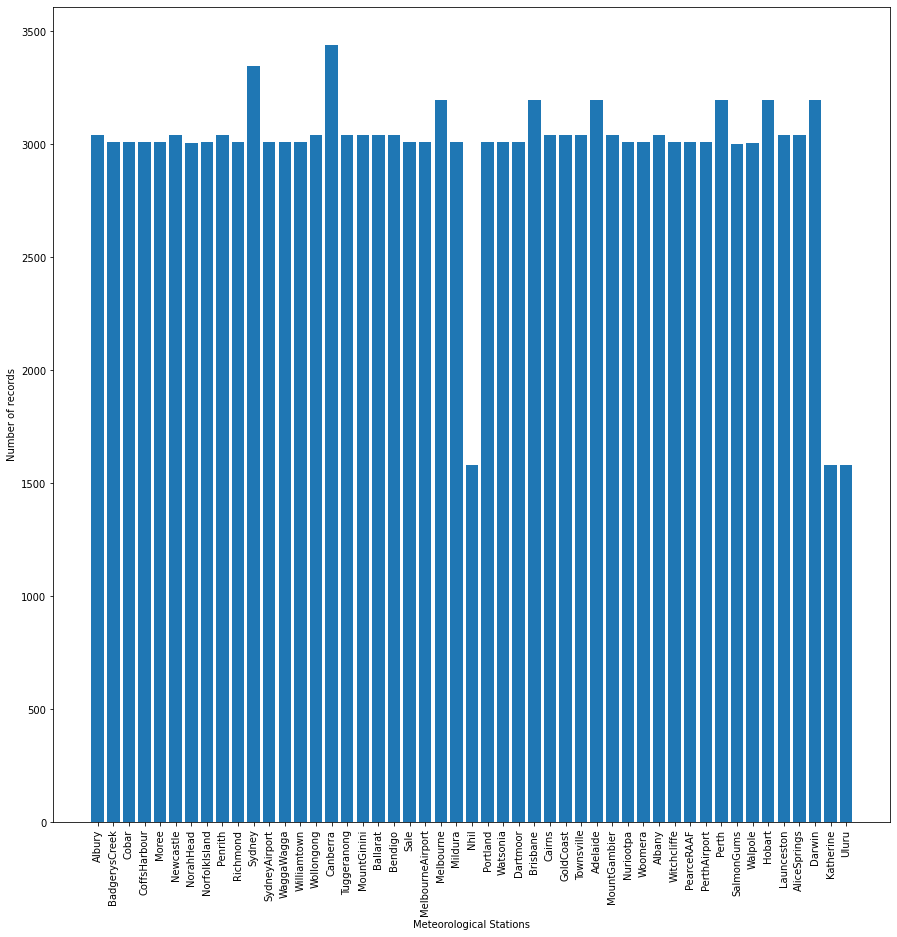

In [21]:
print(data['Location'].unique())
print(len(data['Location'].unique()))
print("Number of NaN values: ", data['Location'].isna().sum())

locGraph(data)

Categorical attribute "Location" has 49 unique values and does not contain any NaN values. It represents individual locations of meteorological stations in Australia where weather information was measured.

## Territory

[' NSW' nan ' VIC' ' ACT' ' QLD' ' SA' ' WA' ' TAS' ' NT']
9
Number of NaN values:  24134 

Stations that do not have an assigned territory ['NorfolkIsland' 'SydneyAirport' 'MountGinini' 'MelbourneAirport'
 'GoldCoast' 'Witchcliffe' 'PearceRAAF' 'PerthAirport']


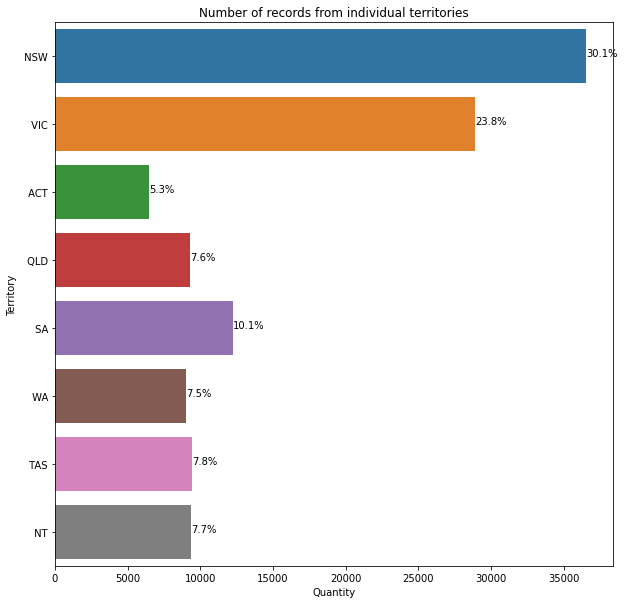

In [22]:
print(data['Territory'].unique())
print(len(data['Territory'].unique()))
print("Number of NaN values: ", data['Territory'].isna().sum(), "\n")

nan_territory = np.where(data['Territory'].isna())
list_nan_territory = np.array(nan_territory).tolist()
location = data.iloc[list_nan_territory[0], data.columns.get_loc('Location')]
print("Stations that do not have an assigned territory", location.unique())
data = data.drop(data.index[list_nan_territory[0]])
data.index = range(len(data.index))

territoryGraph(data)

Attribute "Territory" represents the territories of Australia. It contains 9 unique values but one of it is a NaN value. Meteorological stations that do not have an assigned territory are written above the graph. In the graph, we can see the number of records from meteorological stations for individual territories.

Rows that had a NaN value in the "Territory" column are removed from the dataset.

In [23]:
print(data['Territory'].unique())
print(len(data['Territory'].unique()))
print("Number of NaN values: ", data['Territory'].isna().sum(), "\n")

[' NSW' ' VIC' ' ACT' ' QLD' ' SA' ' WA' ' TAS' ' NT']
8
Number of NaN values:  0 



## WindGustDir

['W' 'WNW' 'WSW' 'NE' 'NNW' 'N' 'NNE' 'SW' nan 'ENE' 'SSE' 'S' 'NW' 'SE'
 'ESE' 'E' 'SSW']
17
Number of NaN values: 9551 what does it represent 7.9 %


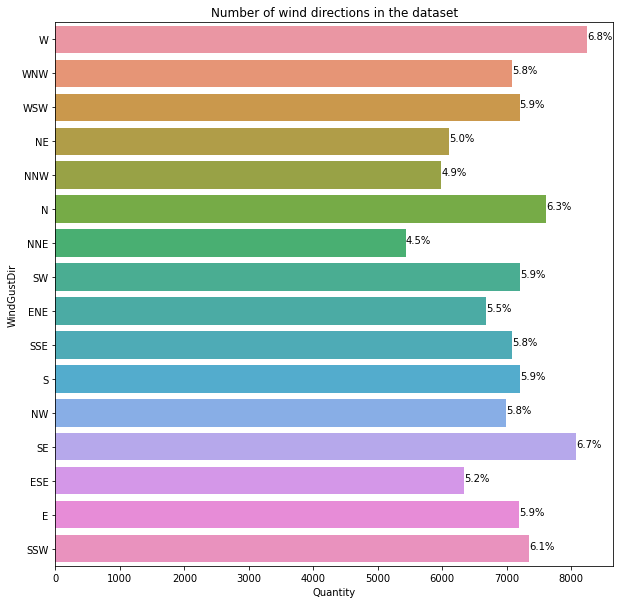

In [24]:
print(data['WindGustDir'].unique())
print(len(data['WindGustDir'].unique()))
print("Number of NaN values:", data['WindGustDir'].isna().sum(), "what does it represent", round((data['WindGustDir'].isna().sum()/len(data['WindGustDir']))*100, 1), "%")

windGraph(data)

This attribute represents wind directions from all meteorological station, also contains some NaN values.

## Rain Today and Rain Tomorrow

These two attributes represent a binary classification, this binary classification is changed to 1 or 0 instead of 'Yes' or 'No' in order to work with them better.

In [25]:
print(data.iloc[:, 21:23].head(10))
print("Number of NaN values: ", data['Location'].isna().sum())

  RainToday RainTomorrow
0        No           No
1        No           No
2        No           No
3        No           No
4        No           No
5        No           No
6        No           No
7        No           No
8        No          Yes
9       Yes           No
Number of NaN values:  0


In [26]:
data['RainToday'] = data['RainToday'].apply(lambda x: 1 if x =='Yes' else 0)
data['RainTomorrow'] = data['RainTomorrow'].apply(lambda x: 1 if x =='Yes' else 0)

In [27]:
data.iloc[:, 21:23].head(10)

RainToday  RainTomorrow
0          0             0
1          0             0
2          0             0
3          0             0
4          0             0
5          0             0
6          0             0
7          0             0
8          0             1
9          1             0

# Analysis of continuous attributes <a class="anchor" id="third"></a>

Some specific continuous attributes for individual weather meteorological stations with NaN value were replaced by the mean. If some meteorological stations still contained NaN values ​​for a specific attributes, then they were filled using the interpolate() function, first with the forward attribute and then with the backward attribute. For this case, is chosen the linear filling method.

For continuous attributes are drawn 5 graphs:
* QQ plot
* Boxplot
* Histogram
* Density plot
* PP plot

## MinTemp

Number of nan values
1358
------------------------
Max		Min		Average		Median
33.9 		 -8.2 		 12.17 		 11.8
------------------------------------------------
Variance	Standard deviation		Range of variation		Average absolute deviation
41.63 		 6.45 				 42.1 				 5.29
------------------------------------------------
Lower quartile, 25%			Upper quartile, 75%			Interquartile range
7.5 					 16.8 					 9.3

Number of skewed lower outliers		Number of skewed upper outliers		Interquartile deviation
15 					 7 					 4.65

Number of extreme lower outliers	Number of extreme upper outliers
0 					 0
------------------------------------------------
Skewness				Kurtosis
0.09676648571953267 		 -0.5356984986961444


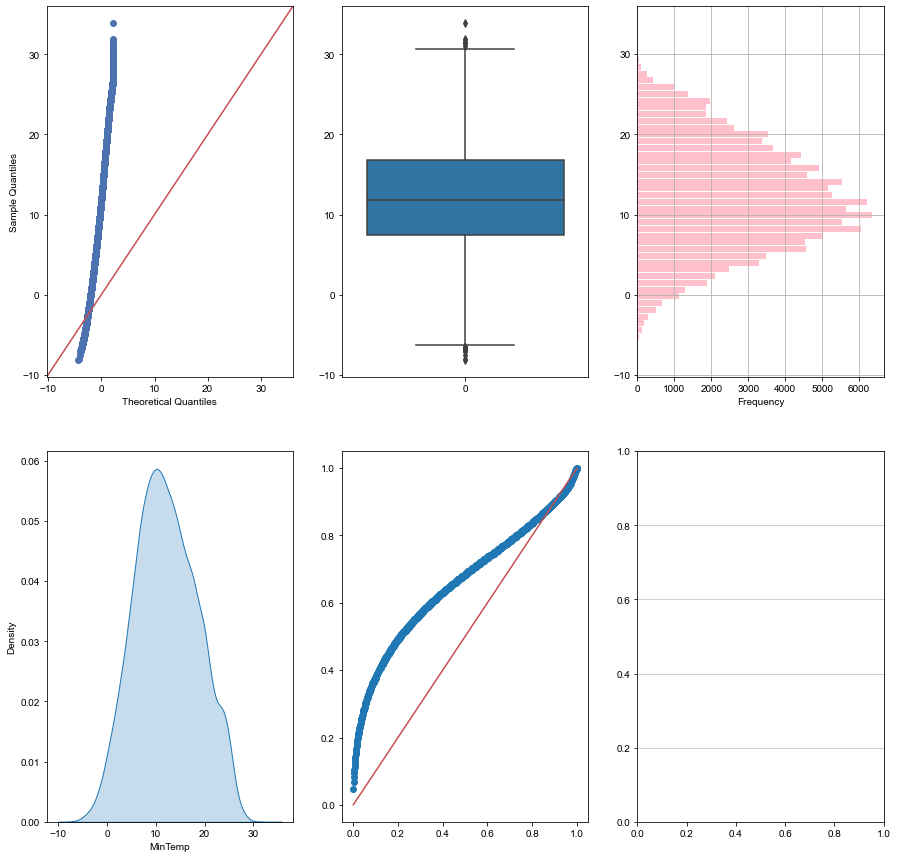

In [28]:
calculate_stats(data['MinTemp'])
tmp = data['MinTemp'].copy()
createGraphs(tmp)

The attribute tells about the minimum temperature in degrees celsius for a specific date and a specific location. We can see that this attribute has some outliers, but they are just skewed. The attribute also contains NaN values. The graphs indicate that this attribute should be from a normal distribution.

### Filling NaN values ​​for the MinTemp attribute

In [29]:
data['MinTemp'] = fillNan(data, 'MinTemp', data.columns.get_loc('MinTemp'))
calculate_stats(data['MinTemp'])

Number of nan values
0
------------------------
Max		Min		Average		Median
33.9 		 -8.2 		 12.17 		 11.8
------------------------------------------------
Variance	Standard deviation		Range of variation		Average absolute deviation
41.22 		 6.42 				 42.1 				 5.25
------------------------------------------------
Lower quartile, 25%			Upper quartile, 75%			Interquartile range
7.5 					 16.8 					 9.3

Number of skewed lower outliers		Number of skewed upper outliers		Interquartile deviation
15 					 7 					 4.65

Number of extreme lower outliers	Number of extreme upper outliers
0 					 0
------------------------------------------------
Skewness				Kurtosis
0.09584214747387299 		 -0.5141723109494896


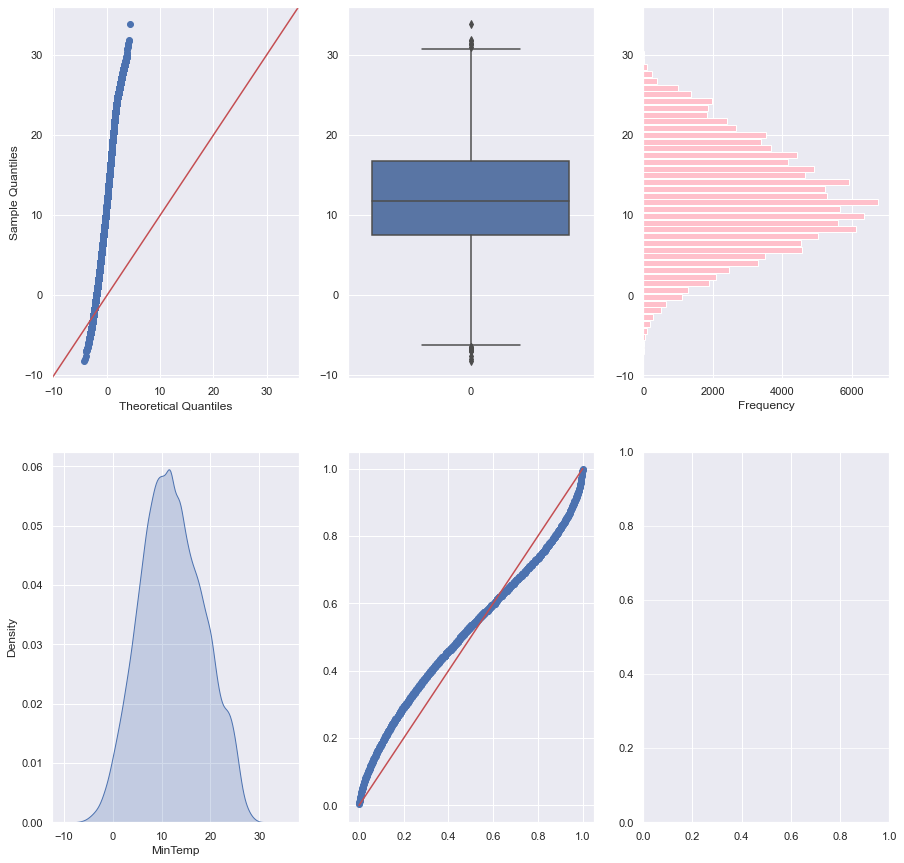

In [30]:
tmp = data['MinTemp'].copy()
createGraphs(tmp)

The NaN values ​​were replaced and as we can see the statistics and graphs before and after replacing the values ​​did not change significantly.

## MaxTemp

Number of nan values
1173
------------------------
Max		Min		Average		Median
48.1 		 2.6 		 23.45 		 22.8
------------------------------------------------
Variance	Standard deviation		Range of variation		Average absolute deviation
50.28 		 7.09 				 45.5 				 5.89
------------------------------------------------
Lower quartile, 25%			Upper quartile, 75%			Interquartile range
17.9 					 28.6 					 10.7

Number of skewed lower outliers		Number of skewed upper outliers		Interquartile deviation
0 					 64 					 5.35

Number of extreme lower outliers	Number of extreme upper outliers
0 					 0
------------------------------------------------
Skewness				Kurtosis
0.33224318245430906 		 -0.550880010576436


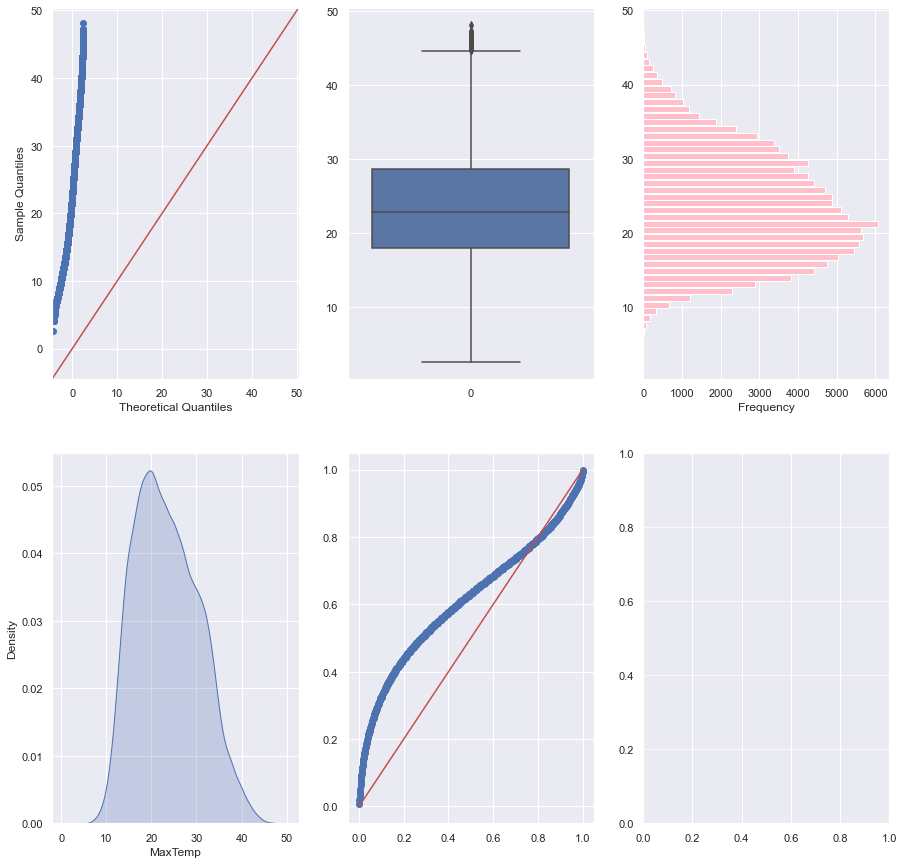

In [31]:
calculate_stats(data['MaxTemp'])
tmp = data['MaxTemp'].copy()
createGraphs(tmp)

The attribute represents the highest temperature in degrees celsius for a specific date and meteorological station. This attribute has some outliers. There are some NaN values. From the graphs, this attribute is most similar to the normal distribution.

### Filling NaN values ​​for the MaxTemp attribute

In [32]:
data['MaxTemp'] = fillNan(data, 'MaxTemp', data.columns.get_loc('MaxTemp'))
calculate_stats(data['MaxTemp'])

Number of nan values
0
------------------------
Max		Min		Average		Median
48.1 		 2.6 		 23.44 		 22.8
------------------------------------------------
Variance	Standard deviation		Range of variation		Average absolute deviation
49.89 		 7.06 				 45.5 				 5.86
------------------------------------------------
Lower quartile, 25%			Upper quartile, 75%			Interquartile range
17.9 					 28.6 					 10.7

Number of skewed lower outliers		Number of skewed upper outliers		Interquartile deviation
0 					 64 					 5.35

Number of extreme lower outliers	Number of extreme upper outliers
0 					 0
------------------------------------------------
Skewness				Kurtosis
0.3380006034589427 		 -0.5323365812468102


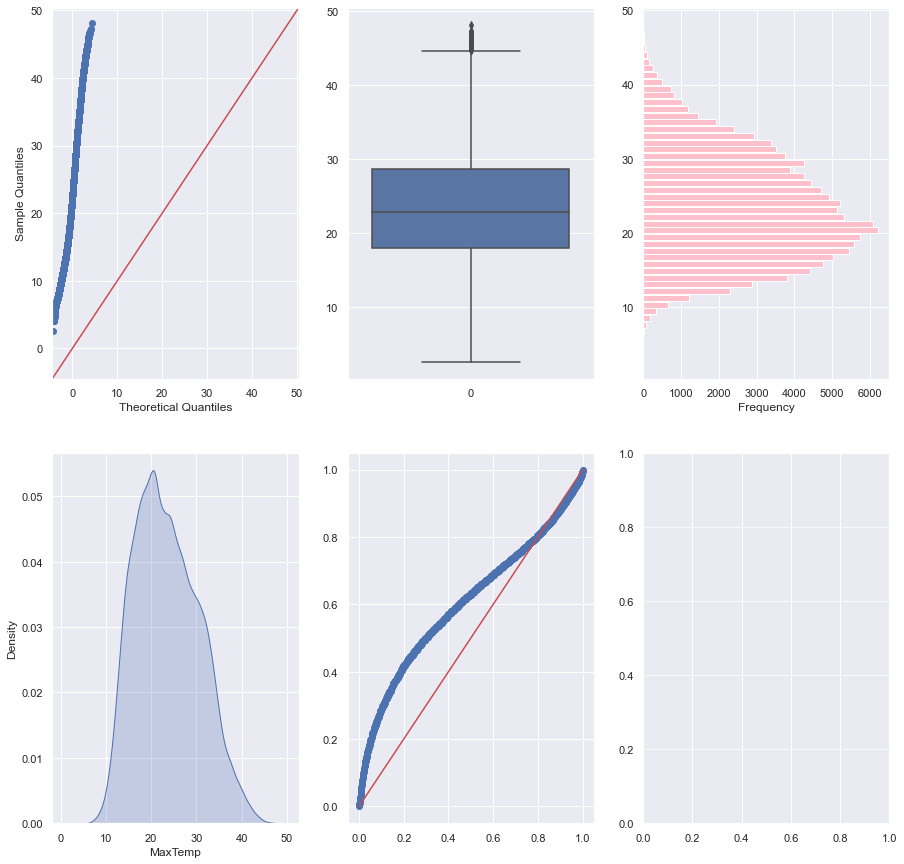

In [33]:
tmp = data['MaxTemp'].copy()
createGraphs(tmp)

After replacing NaN values, we can see that the statistics and graphs before and after did not change significantly.

## Rainfall

Number of nan values
2715
------------------------
Max		Min		Average		Median
371.0 		 0.0 		 2.31 		 0.0
------------------------------------------------
Variance	Standard deviation		Range of variation		Average absolute deviation
72.03 		 8.49 				 371.0 				 3.56
------------------------------------------------
Lower quartile, 25%			Upper quartile, 75%			Interquartile range
0.0 					 0.6 					 0.6

Number of skewed lower outliers		Number of skewed upper outliers		Interquartile deviation
0 					 23587 					 0.3

Number of extreme lower outliers	Number of extreme upper outliers
0 					 19331
------------------------------------------------
Skewness				Kurtosis
10.35066175313813 		 197.42825080980802


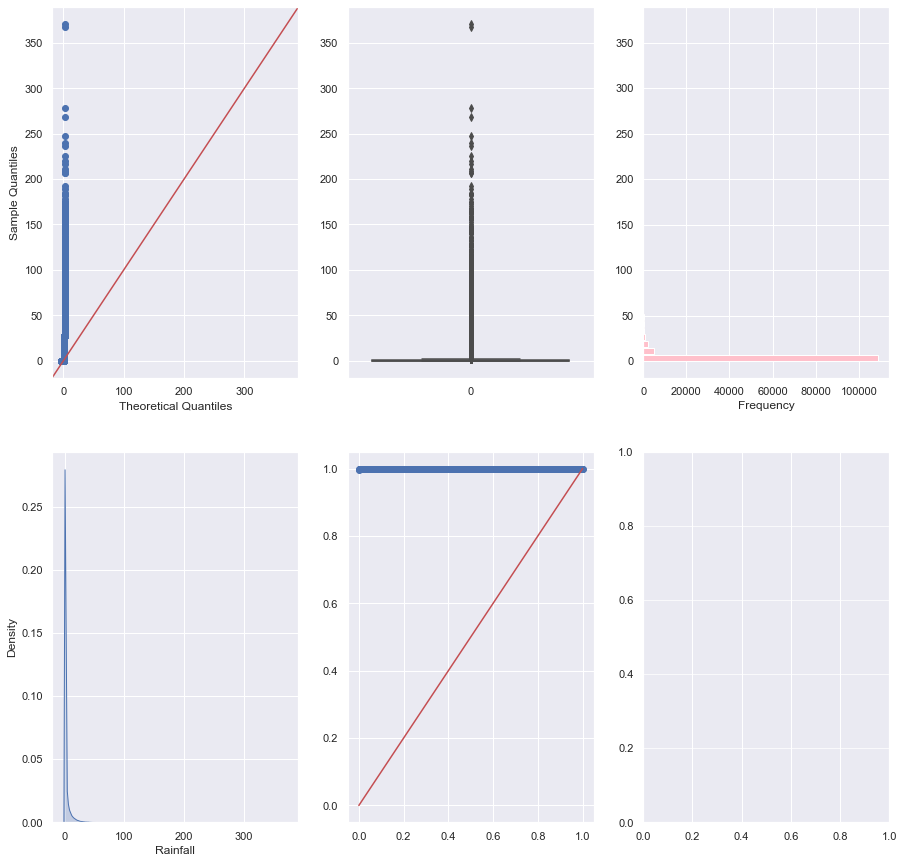

In [34]:
calculate_stats(data['Rainfall'])
tmp = data['Rainfall'].copy()
createGraphs(tmp)

This attribute is interesting, it tells about the number of precipitation in mm and from the graphs we can notice that the most numerous value is 0. We can also notice that it contains almost 20,000 upper extreme outliers. I decided not to remove all of these outliers and leave some of them as they are because these weather records are from different territories and if I remove the outliers I might lose some records from meteorological station, so they can be high leverage points. This attribute also contains NaN values. 

### Filling NaN values ​​for the Rainfall attribute

In [35]:
data['Rainfall'] = fillNan(data, 'Rainfall', data.columns.get_loc('Rainfall'))
calculate_stats(data['Rainfall'])

Number of nan values
0
------------------------
Max		Min		Average		Median
371.0 		 0.0 		 2.31 		 0.0
------------------------------------------------
Variance	Standard deviation		Range of variation		Average absolute deviation
70.44 		 8.39 				 371.0 				 3.5
------------------------------------------------
Lower quartile, 25%			Upper quartile, 75%			Interquartile range
0.0 					 0.8 					 0.8

Number of skewed lower outliers		Number of skewed upper outliers		Interquartile deviation
0 					 22261 					 0.4

Number of extreme lower outliers	Number of extreme upper outliers
0 					 17596
------------------------------------------------
Skewness				Kurtosis
10.462014024704006 		 201.86269791674687


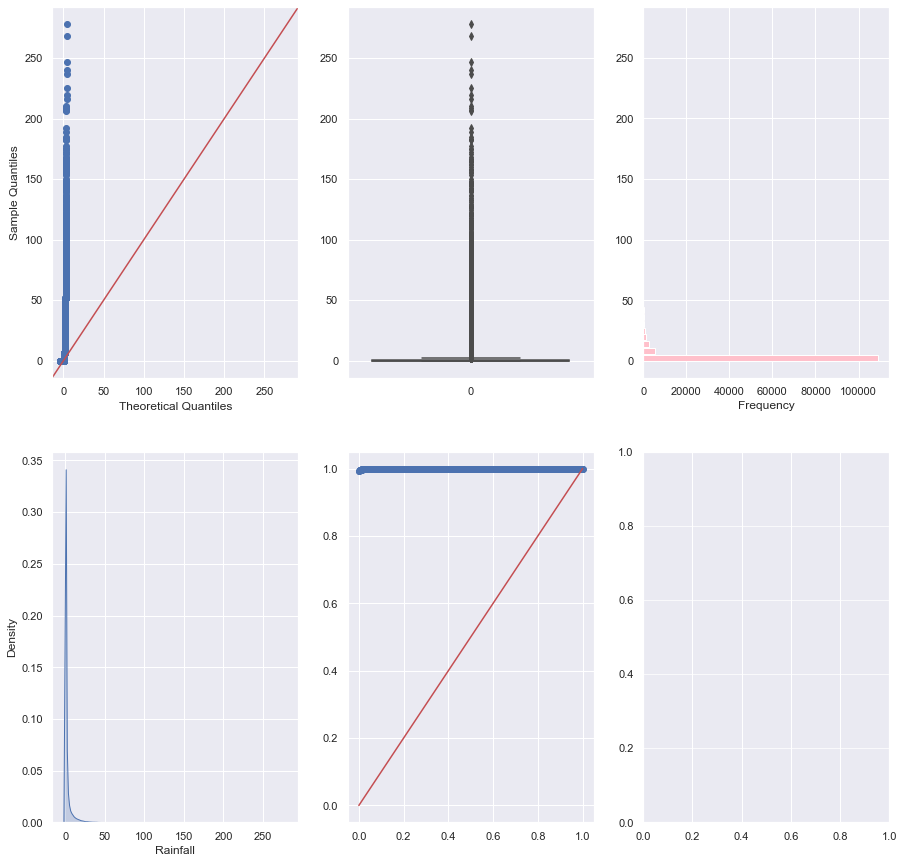

In [36]:
outliers = np.where(data['Rainfall'] > 350)
list_outliers = np.array(outliers).tolist()
data = data.drop(data.index[list_outliers[0]])
data.index = range(len(data.index))

tmp = data['Rainfall'].copy()
createGraphs(tmp)

Removed outliers - above 350

After the replacement, there are no significant changes in the statistics or in the graphs, drop of the upper extreme outliers by about 2000. The data distribution is closest to the logarithmic distribution.

## Evaporation

Number of nan values
50406
------------------------
Max		Min		Average		Median
145.0 		 0.0 		 5.53 		 4.8
------------------------------------------------
Variance	Standard deviation		Range of variation		Average absolute deviation
18.86 		 4.34 				 145.0 				 3.0
------------------------------------------------
Lower quartile, 25%			Upper quartile, 75%			Interquartile range
2.6 					 7.4 					 4.8

Number of skewed lower outliers		Number of skewed upper outliers		Interquartile deviation
0 					 1912 					 2.4

Number of extreme lower outliers	Number of extreme upper outliers
0 					 476
------------------------------------------------
Skewness				Kurtosis
3.80954993315141 		 44.380393509508295


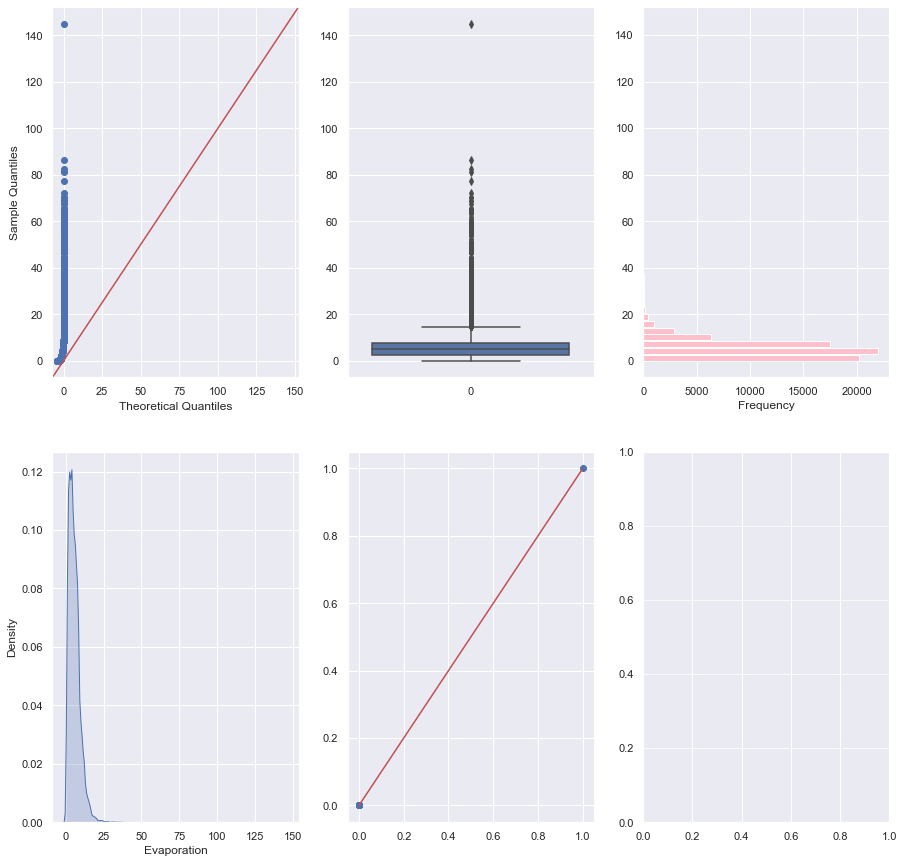

In [37]:
calculate_stats(data['Evaporation'])
tmp = data['Evaporation'].copy()
createGraphs(tmp)

This attribute tells about evaporation in mm. It contains upper extreme outliers. The most numerous value in this attribute it is something above the value 0. Also, this attribute contains around 50,000 NaN values.

### Filling NaN values ​​for the Evaporation attribute

In [38]:
data['Evaporation'] = fillNan(data, 'Evaporation', data.columns.get_loc('Evaporation'))
calculate_stats(data['Evaporation'])

Number of nan values
0
------------------------
Max		Min		Average		Median
145.0 		 0.0 		 5.77 		 5.4
------------------------------------------------
Variance	Standard deviation		Range of variation		Average absolute deviation
14.06 		 3.75 				 145.0 				 2.58
------------------------------------------------
Lower quartile, 25%			Upper quartile, 75%			Interquartile range
3.4 					 7.2 					 3.8

Number of skewed lower outliers		Number of skewed upper outliers		Interquartile deviation
0 					 3127 					 1.9

Number of extreme lower outliers	Number of extreme upper outliers
0 					 758
------------------------------------------------
Skewness				Kurtosis
3.5038316766612656 		 46.40148799427946


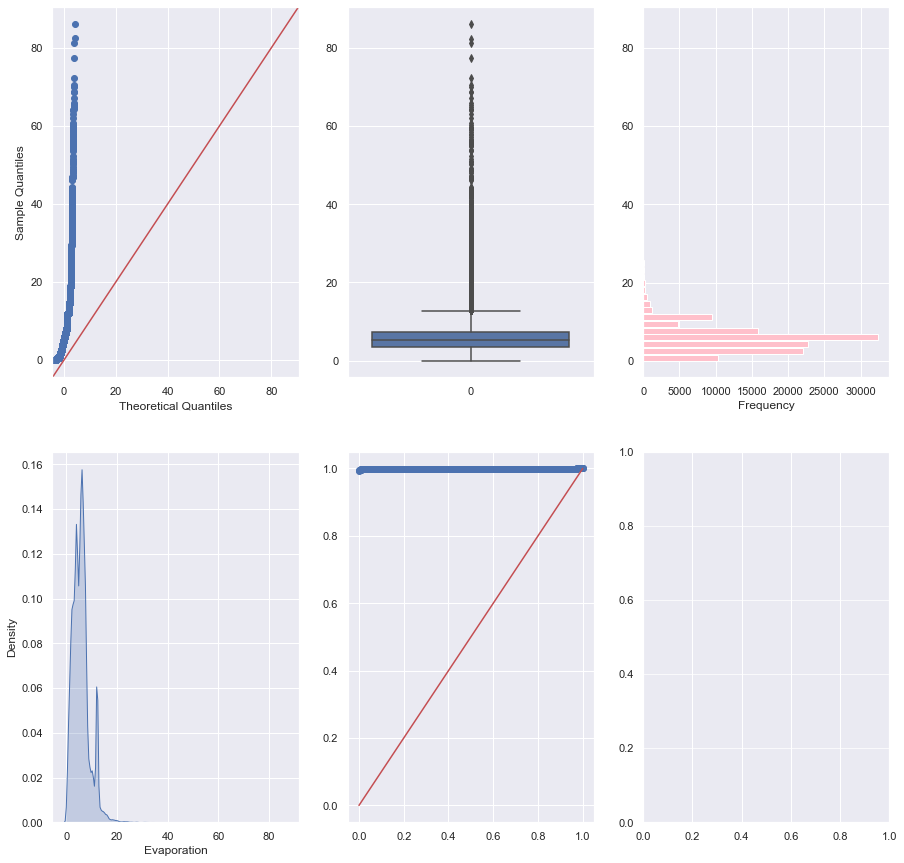

In [39]:
outliers = np.where(data['Evaporation'] > 100)
list_outliers = np.array(outliers).tolist()
data = data.drop(data.index[list_outliers[0]])
data.index = range(len(data.index))

tmp = data['Evaporation'].copy()
createGraphs(tmp)

Removed outliers around the value 140.

Before and after replacing NaN values, we can notice minor differences in the statistics and also in the graphs. The data distribution is closest to the logarithmic distribution.

## Sunshine

Number of nan values
60279
------------------------
Max		Min		Average		Median
14.5 		 0.0 		 7.6 		 8.4
------------------------------------------------
Variance	Standard deviation		Range of variation		Average absolute deviation
14.35 		 3.79 				 14.5 				 3.21
------------------------------------------------
Lower quartile, 25%			Upper quartile, 75%			Interquartile range
4.8 					 10.7 					 5.9

Number of skewed lower outliers		Number of skewed upper outliers		Interquartile deviation
0 					 0 					 2.95

Number of extreme lower outliers	Number of extreme upper outliers
0 					 0
------------------------------------------------
Skewness				Kurtosis
-0.49593639566262976 		 -0.8428376874002721


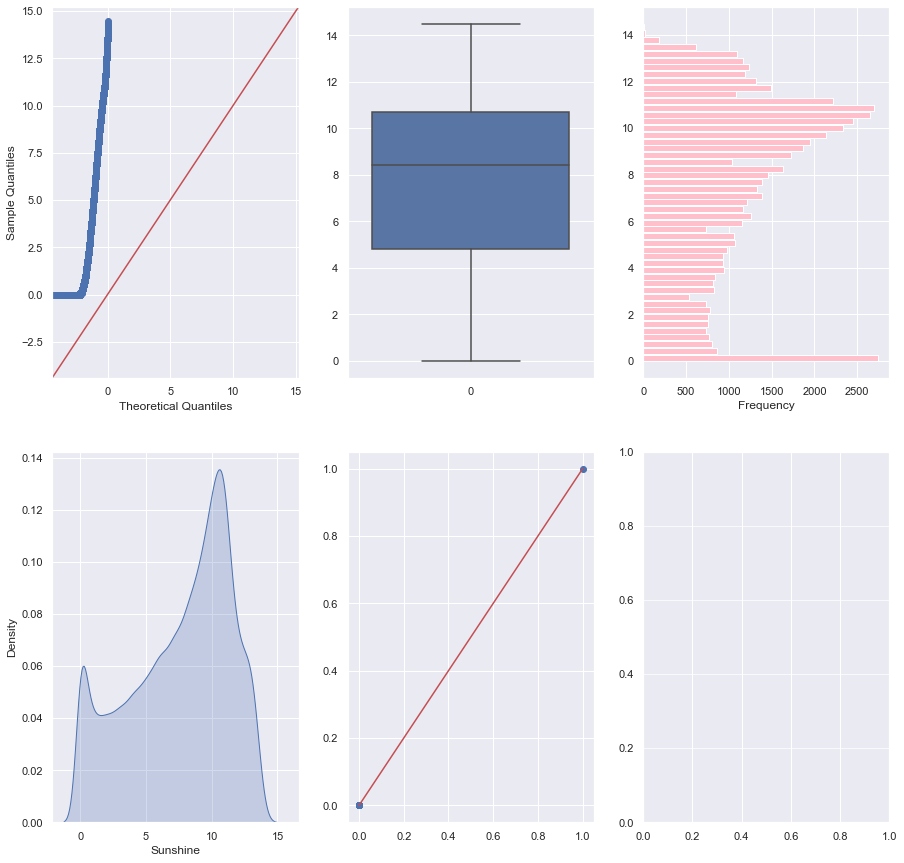

In [40]:
calculate_stats(data['Sunshine'])
tmp = data['Sunshine'].copy()
createGraphs(tmp)

This attribute shows the number of hours the sun shone on a specific day. It does not contain any outliers but has NaN values.

### Filling NaN values ​​for the Sunshine attribute

In [41]:
data['Sunshine'] = fillNan(data, 'Sunshine', data.columns.get_loc('Sunshine'))
calculate_stats(data['Sunshine'])

Number of nan values
0
------------------------
Max		Min		Average		Median
14.5 		 0.0 		 7.67 		 7.87
------------------------------------------------
Variance	Standard deviation		Range of variation		Average absolute deviation
10.54 		 3.25 				 14.5 				 2.52
------------------------------------------------
Lower quartile, 25%			Upper quartile, 75%			Interquartile range
6.3 					 10.0 					 3.7

Number of skewed lower outliers		Number of skewed upper outliers		Interquartile deviation
5155 					 0 					 1.85

Number of extreme lower outliers	Number of extreme upper outliers
0 					 0
------------------------------------------------
Skewness				Kurtosis
-0.5442481103792045 		 -0.18614117869910363


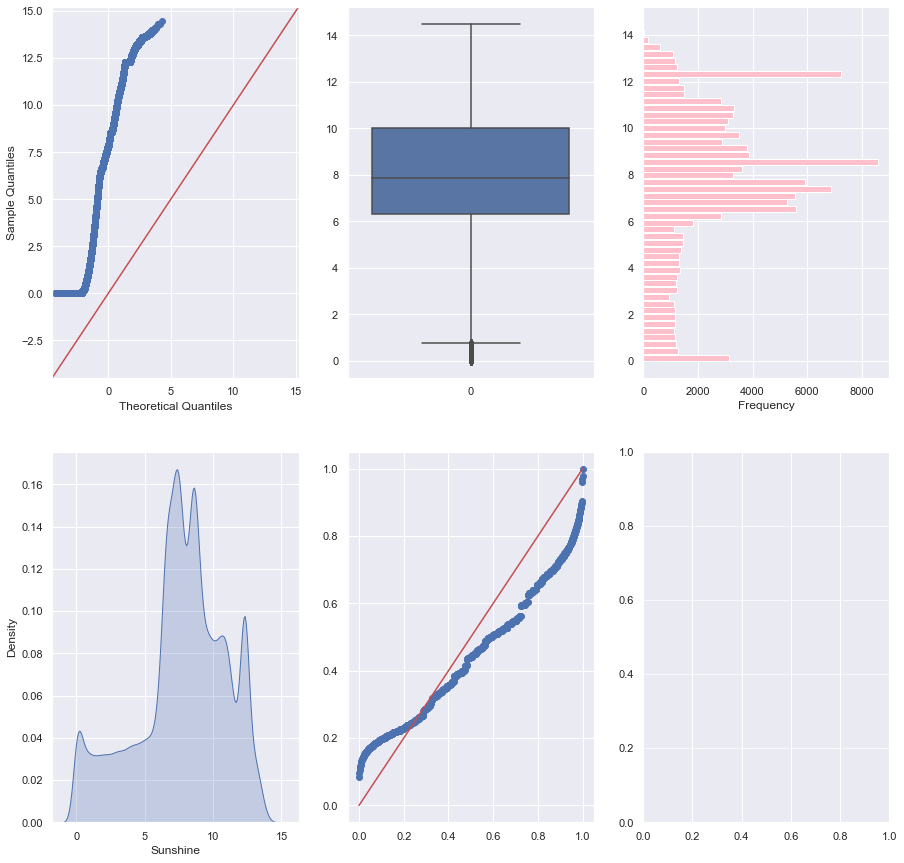

In [42]:
tmp = data['Sunshine'].copy()
createGraphs(tmp)

The differences before and after the replacement are visible in the statistics, the bottom skewed outliers have increased. Other values ​​did not change significantly, minor differences in some graphs.

## WindGustSpeed

Number of nan values
9488
------------------------
Max		Min		Average		Median
135.0 		 6.0 		 39.17 		 37.0
------------------------------------------------
Variance	Standard deviation		Range of variation		Average absolute deviation
178.95 		 13.38 				 129.0 				 10.29
------------------------------------------------
Lower quartile, 25%			Upper quartile, 75%			Interquartile range
30.0 					 46.0 					 16.0

Number of skewed lower outliers		Number of skewed upper outliers		Interquartile deviation
0 					 2779 					 8.0

Number of extreme lower outliers	Number of extreme upper outliers
0 					 208
------------------------------------------------
Skewness				Kurtosis
0.9050709842090183 		 1.6358258075118357


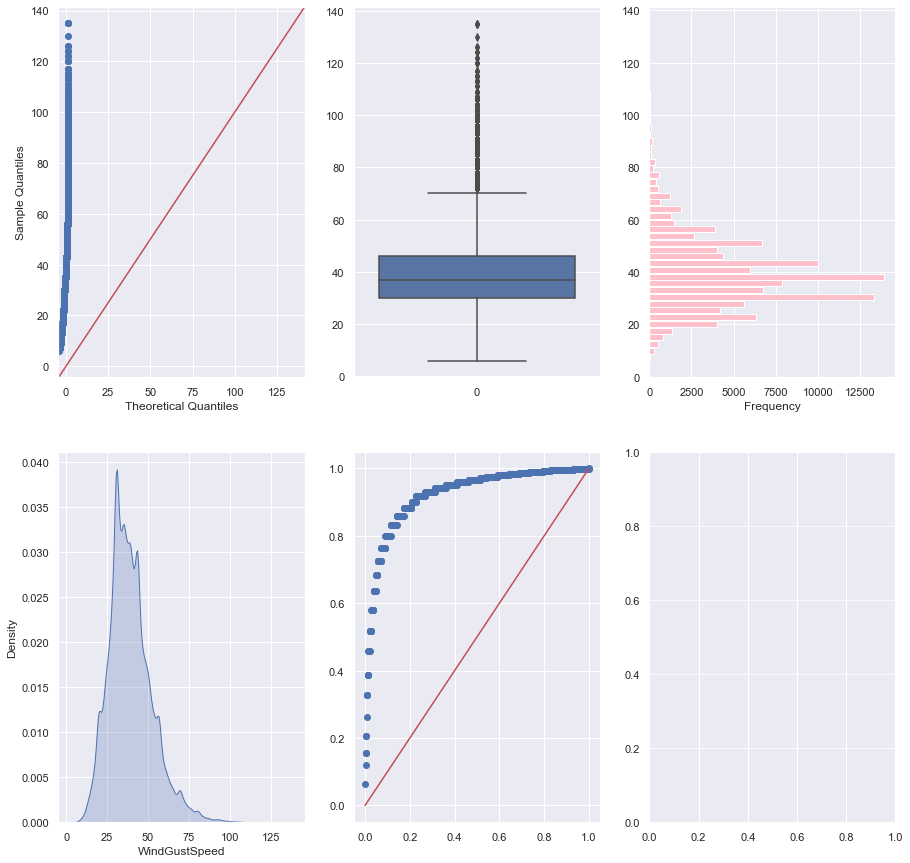

In [43]:
calculate_stats(data['WindGustSpeed'])
tmp = data['WindGustSpeed'].copy()
createGraphs(tmp)

The highest recorded wind speed in km/h. There are upper skewed outliers and also NaN values. The data distribution resembles a logarithmic distribution.

### Filling NaN values ​​for the WindGustSpeed ​​attribute

In [44]:
data['WindGustSpeed'] = fillNan(data, 'WindGustSpeed', data.columns.get_loc('WindGustSpeed'))
calculate_stats(data['WindGustSpeed'])

Number of nan values
0
------------------------
Max		Min		Average		Median
135.0 		 6.0 		 39.07 		 37.0
------------------------------------------------
Variance	Standard deviation		Range of variation		Average absolute deviation
171.82 		 13.11 				 129.0 				 10.01
------------------------------------------------
Lower quartile, 25%			Upper quartile, 75%			Interquartile range
30.0 					 46.0 					 16.0

Number of skewed lower outliers		Number of skewed upper outliers		Interquartile deviation
0 					 2779 					 8.0

Number of extreme lower outliers	Number of extreme upper outliers
0 					 208
------------------------------------------------
Skewness				Kurtosis
0.9051124847108108 		 1.7251420010052287


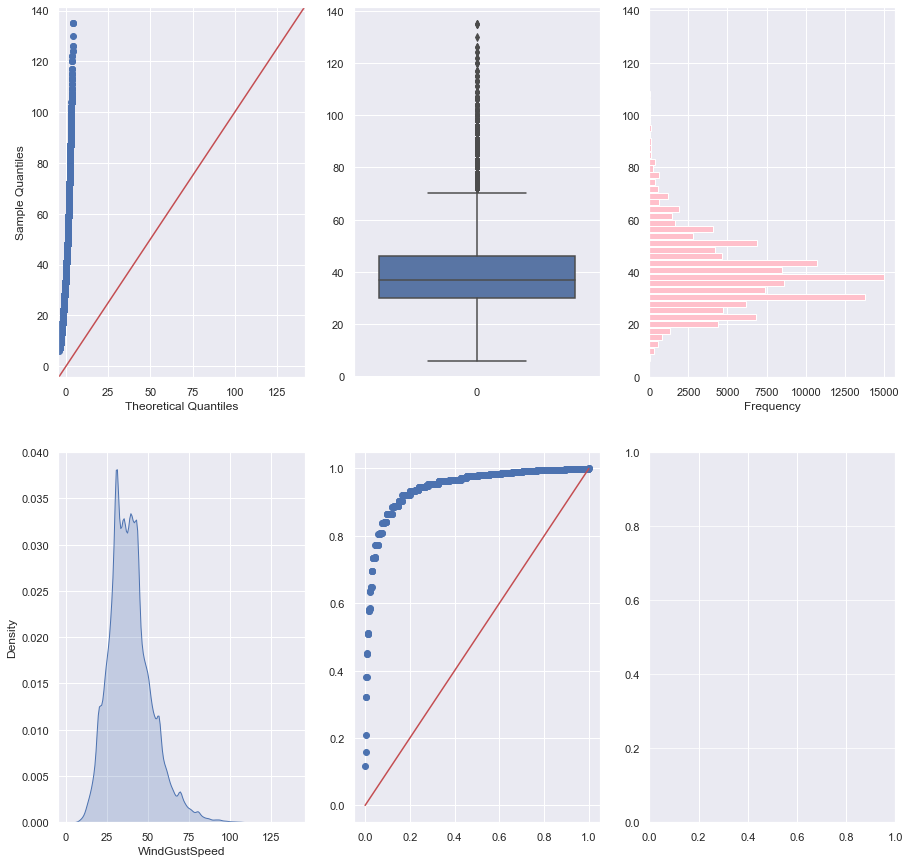

In [45]:
tmp = data['WindGustSpeed'].copy()
createGraphs(tmp)

The difference before and after filling NaN values ​​is not significant in statistics or graphs.

## Humidity3pm

Number of nan values
3907
------------------------
Max		Min		Average		Median
100.0 		 0.0 		 50.69 		 51.0
------------------------------------------------
Variance	Standard deviation		Range of variation		Average absolute deviation
435.22 		 20.86 				 100.0 				 17.01
------------------------------------------------
Lower quartile, 25%			Upper quartile, 75%			Interquartile range
36.0 					 65.0 					 29.0

Number of skewed lower outliers		Number of skewed upper outliers		Interquartile deviation
0 					 0 					 14.5

Number of extreme lower outliers	Number of extreme upper outliers
0 					 0
------------------------------------------------
Skewness				Kurtosis
0.04245843649550498 		 -0.5486760147046037


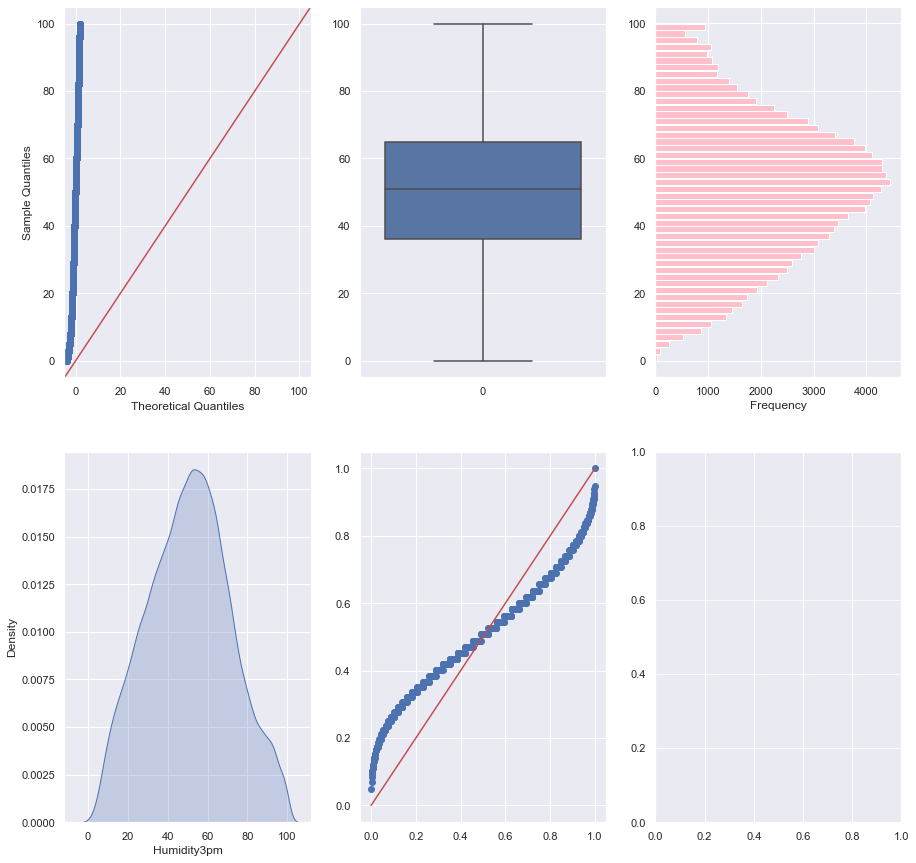

In [46]:
calculate_stats(data['Humidity3pm'])
tmp = data['Humidity3pm'].copy()
createGraphs(tmp)

Attribute that recorded humidity at 3pm in percentage. The attribute has no outliers and has several NaN values. From the graphs, the data could be from a normal distribution.

### Filling NaN values ​​for attribute Humidity3pm

In [47]:
data['Humidity3pm'] = fillNan(data, 'Humidity3pm', data.columns.get_loc('Humidity3pm'))
calculate_stats(data['Humidity3pm'])

Number of nan values
0
------------------------
Max		Min		Average		Median
100.0 		 0.0 		 50.8 		 51.0
------------------------------------------------
Variance	Standard deviation		Range of variation		Average absolute deviation
424.71 		 20.61 				 100.0 				 16.74
------------------------------------------------
Lower quartile, 25%			Upper quartile, 75%			Interquartile range
36.0 					 65.0 					 29.0

Number of skewed lower outliers		Number of skewed upper outliers		Interquartile deviation
0 					 0 					 14.5

Number of extreme lower outliers	Number of extreme upper outliers
0 					 0
------------------------------------------------
Skewness				Kurtosis
0.029409162323539947 		 -0.5051354459676984


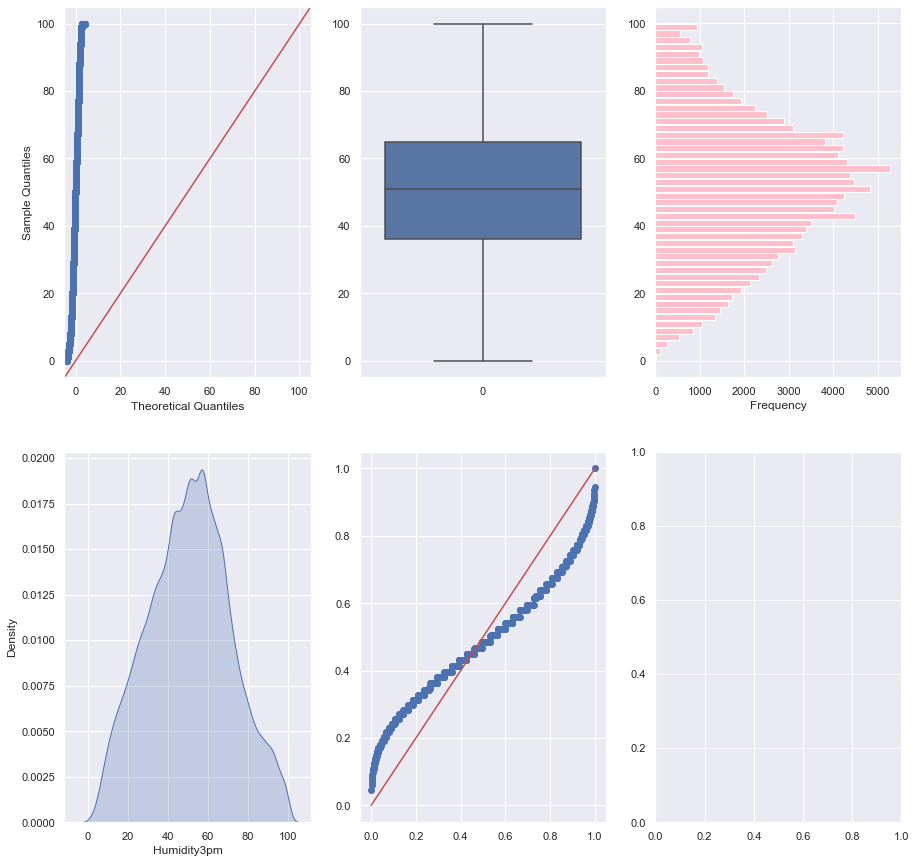

In [48]:
tmp = data['Humidity3pm'].copy()
createGraphs(tmp)

Before and after filling the NaN values, statistically there are no significant changes, but smaller changes can be seen in the graphs.

## Pressure3pm

Number of nan values
11819
------------------------
Max		Min		Average		Median
1039.6 		 977.1 		 1015.16 		 1015.1
------------------------------------------------
Variance	Standard deviation		Range of variation		Average absolute deviation
51.2 		 7.16 				 62.5 				 5.71
------------------------------------------------
Lower quartile, 25%			Upper quartile, 75%			Interquartile range
1010.2 					 1020.0 					 9.8

Number of skewed lower outliers		Number of skewed upper outliers		Interquartile deviation
524 					 237 					 4.9

Number of extreme lower outliers	Number of extreme upper outliers
4 					 0
------------------------------------------------
Skewness				Kurtosis
-0.03349590160695734 		 0.10417886324265524


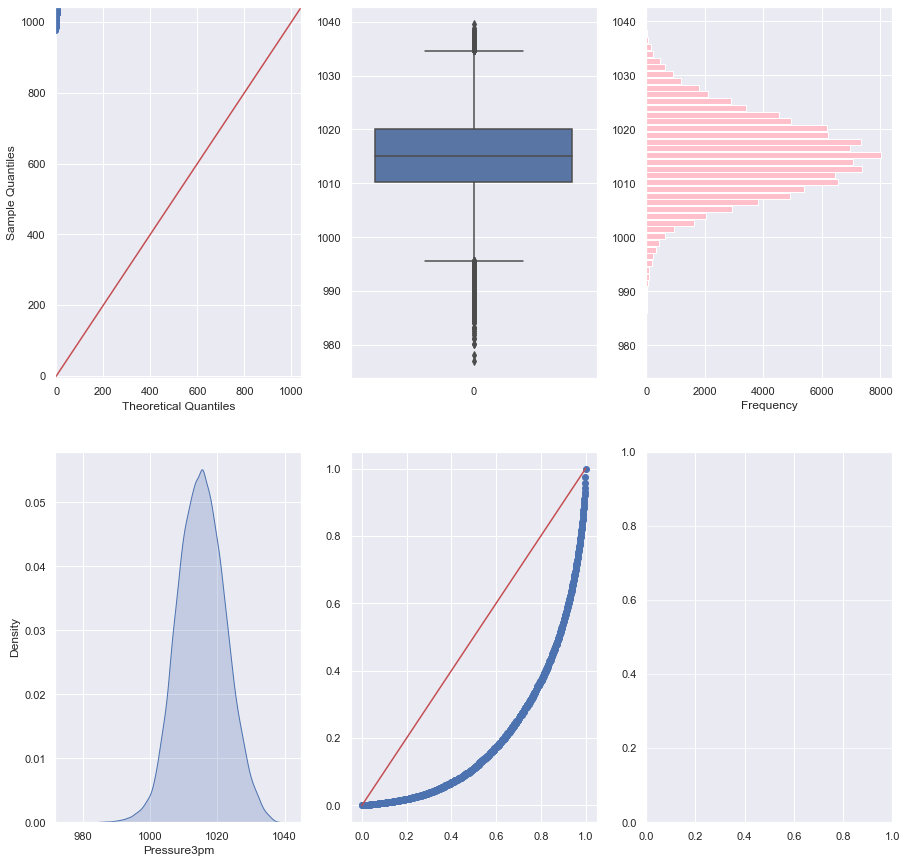

In [49]:
calculate_stats(data['Pressure3pm'])
tmp = data['Pressure3pm'].copy()
createGraphs(tmp)

The attribute pressure at 3pm is measured in hpa. We can see that it contains a pair of upper and lower outliers and also NaN values. The data distribution is most similar to the normal distribution.

### Filling NaN values ​​for the Pressure3pm attribute

In [50]:
data['Pressure3pm'] = fillNan(data, 'Pressure3pm', data.columns.get_loc('Pressure3pm'))
calculate_stats(data['Pressure3pm'])

Number of nan values
0
------------------------
Max		Min		Average		Median
1039.6 		 977.1 		 1014.96 		 1014.91
------------------------------------------------
Variance	Standard deviation		Range of variation		Average absolute deviation
50.01 		 7.07 				 62.5 				 5.62
------------------------------------------------
Lower quartile, 25%			Upper quartile, 75%			Interquartile range
1010.1 					 1019.7 					 9.6

Number of skewed lower outliers		Number of skewed upper outliers		Interquartile deviation
539 					 311 					 4.8

Number of extreme lower outliers	Number of extreme upper outliers
5 					 0
------------------------------------------------
Skewness				Kurtosis
-0.014071345377914646 		 0.09015091521866303


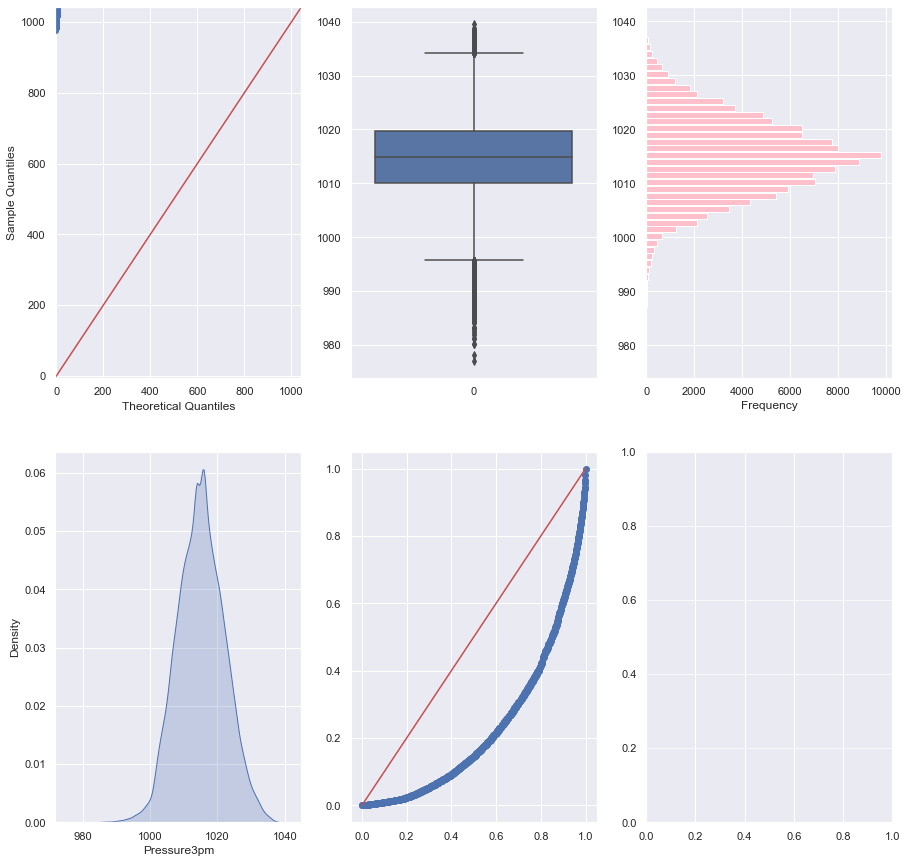

In [51]:
tmp = data['Pressure3pm'].copy()
createGraphs(tmp)

Before and after, the difference in statistics and graphs is not significant.

## Cloud3pm

Number of nan values
49075
------------------------
Max		Min		Average		Median
9.0 		 0.0 		 4.53 		 5.0
------------------------------------------------
Variance	Standard deviation		Range of variation		Average absolute deviation
7.46 		 2.73 				 9.0 				 2.48
------------------------------------------------
Lower quartile, 25%			Upper quartile, 75%			Interquartile range
2.0 					 7.0 					 5.0

Number of skewed lower outliers		Number of skewed upper outliers		Interquartile deviation
0 					 0 					 2.5

Number of extreme lower outliers	Number of extreme upper outliers
0 					 0
------------------------------------------------
Skewness				Kurtosis
-0.2305371398404575 		 -1.457485854827468


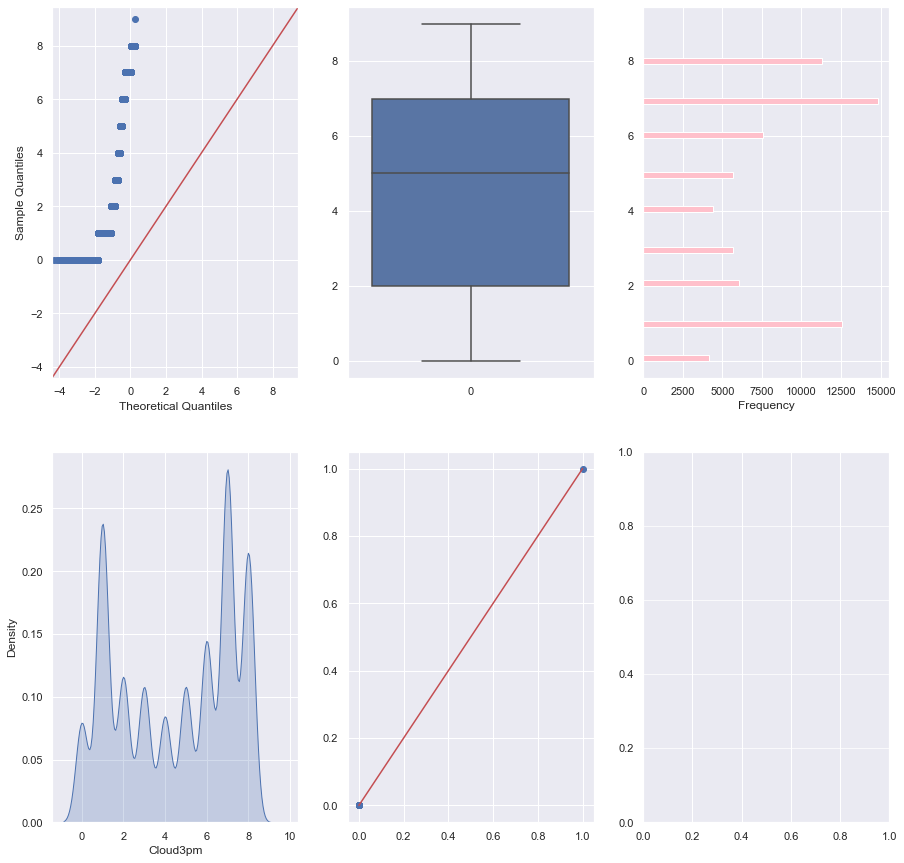

In [52]:
calculate_stats(data['Cloud3pm'])
tmp = data['Cloud3pm'].copy()
createGraphs(tmp)

This attribute is measured in oktas, which tells about the amount of cloud cover. This attribute has a couple of specific values, which can also be seen on the histogram. There are no outliers, but it has several NaN values.

### Filling NaN values ​​for the Cloud3pm attribute

In [53]:
data['Cloud3pm'] = fillNan(data, 'Cloud3pm', data.columns.get_loc('Cloud3pm'))
calculate_stats(data['Cloud3pm'])

Number of nan values
0
------------------------
Max		Min		Average		Median
9.0 		 0.0 		 4.7 		 5.0
------------------------------------------------
Variance	Standard deviation		Range of variation		Average absolute deviation
4.94 		 2.22 				 9.0 				 1.8
------------------------------------------------
Lower quartile, 25%			Upper quartile, 75%			Interquartile range
3.1 					 6.3 					 3.24

Number of skewed lower outliers		Number of skewed upper outliers		Interquartile deviation
0 					 0 					 1.62

Number of extreme lower outliers	Number of extreme upper outliers
0 					 0
------------------------------------------------
Skewness				Kurtosis
-0.44461114929694057 		 -0.7024992822276692


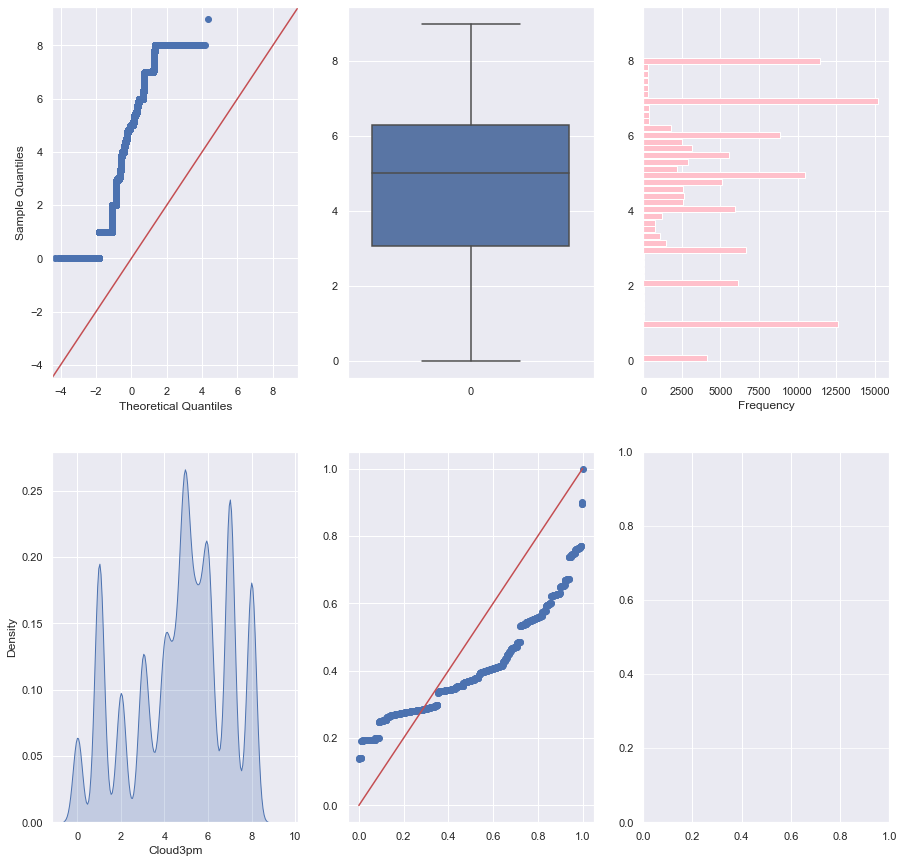

In [54]:
tmp = data['Cloud3pm'].copy()
createGraphs(tmp)

Before and after filling the NaN values, the statistics and graphs have changed slightly.

## Temp3pm

Number of nan values
3281
------------------------
Max		Min		Average		Median
46.7 		 1.7 		 21.91 		 21.2
------------------------------------------------
Variance	Standard deviation		Range of variation		Average absolute deviation
47.95 		 6.92 				 45.0 				 5.72
------------------------------------------------
Lower quartile, 25%			Upper quartile, 75%			Interquartile range
16.6 					 26.8 					 10.2

Number of skewed lower outliers		Number of skewed upper outliers		Interquartile deviation
0 					 152 					 5.1

Number of extreme lower outliers	Number of extreme upper outliers
0 					 0
------------------------------------------------
Skewness				Kurtosis
0.3510029620970606 		 -0.4613560099136733


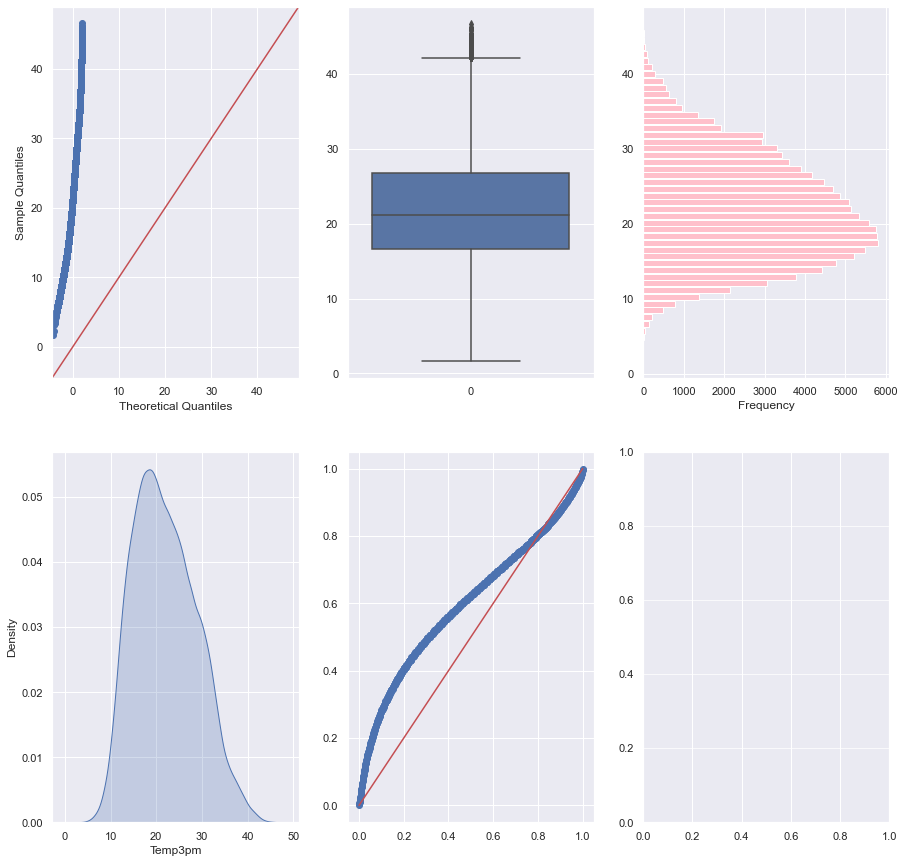

In [55]:
calculate_stats(data['Temp3pm'])
tmp = data['Temp3pm'].copy()
createGraphs(tmp)

The attribute refers to a specific temperature measured at 3pm. It contains several upper skewed outliers and also several NaN values. The data distribution is most similar to the normal distribution.

### Filling NaN values ​​for the Temp3pm attribute

In [56]:
data['Temp3pm'] = fillNan(data, 'Temp3pm', data.columns.get_loc('Temp3pm'))
calculate_stats(data['Temp3pm'])

Number of nan values
0
------------------------
Max		Min		Average		Median
46.7 		 1.7 		 21.95 		 21.3
------------------------------------------------
Variance	Standard deviation		Range of variation		Average absolute deviation
47.59 		 6.9 				 45.0 				 5.68
------------------------------------------------
Lower quartile, 25%			Upper quartile, 75%			Interquartile range
16.7 					 26.8 					 10.1

Number of skewed lower outliers		Number of skewed upper outliers		Interquartile deviation
0 					 178 					 5.05

Number of extreme lower outliers	Number of extreme upper outliers
0 					 0
------------------------------------------------
Skewness				Kurtosis
0.3563030016355286 		 -0.4512286108192187


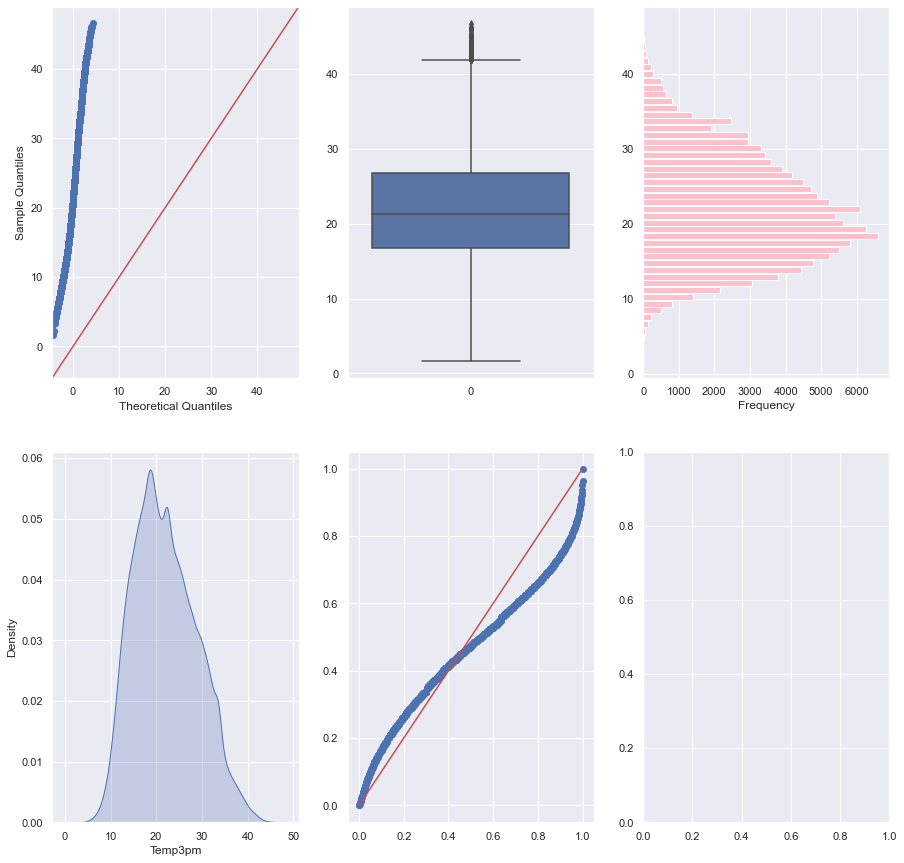

In [57]:
tmp = data['Temp3pm'].copy()
createGraphs(tmp)

The difference before and after did not change significantly for statistics, but we can notice slight changes for the graphs.

# Dataframe modification <a class="anchor" id="fourth"></a>

In this section, some columns will be dropped, these columns are: WindGustDir, WindDir9am, WindDir3pm, WindSpeed9am, WindSpeed3pm, Humidity9am, Pressure9am, Cloud9am, Temp9am. These columns are not interesting for further analysis.

After analyzing the individual attributes, we could notice that in the attributes Evaporation and Sunshine are missing around 50% of the data. They contain a NaN values, these NaN values have been replaced.

In [58]:
data = data.drop(['WindGustDir','WindDir9am',
                  'WindDir3pm','WindSpeed9am',
                  'WindSpeed3pm','Humidity9am',
                  'Pressure9am','Cloud9am','Temp9am'], axis = 1)

In [59]:
data.head(5)

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  01/12/2008   Albury     13.4     22.9       0.6         12.0      12.3   
1  02/12/2008   Albury      7.4     25.1       0.0         12.0      12.3   
2  03/12/2008   Albury     12.9     25.7       0.0         12.0      12.3   
3  04/12/2008   Albury      9.2     28.0       0.0         12.0      12.3   
4  05/12/2008   Albury     17.5     32.3       1.0         12.0      12.3   

   WindGustSpeed  Humidity3pm  Pressure3pm  Cloud3pm  Temp3pm  RainToday  \
0           44.0         22.0       1007.1      5.41     21.8          0   
1           44.0         25.0       1007.8      5.41     24.3          0   
2           46.0         30.0       1008.7      2.00     23.2          0   
3           24.0         16.0       1012.8      5.41     26.5          0   
4           41.0         33.0       1006.0      8.00     29.7          0   

   RainTomorrow Territory  
0             0       NSW  
1             0       NSW  
2             0       NSW  
3             0       NSW  
4             0       NSW

### Outliers

I will create 2 dataframes. In first, outliers will be removed from all attributes.

In the second, I will remove outliers based on the territory.

I do this because I want to continue working with all the data, but also with data based on the territory.

From the analysis of individual attributes, there are skewed and extreme outliers, using Tukey's test I can decide - remove only extreme outliers, both upper and lower.

Outliers from the Rainfall attribute will not be removed, since the most numerous value is 0 and outliers are basically the values ​​of when it rained, in order to preserve information about the number of precipitations. I will not do anything with the attribute Rainfall.

In [60]:
checkOutliers(data)
df = data.copy()

MinTemp - number of extreme outliers 0
MaxTemp - number of extreme outliers 0
Rainfall - number of extreme outliers 17593
Evaporation - number of extreme outliers 757
Sunshine - number of extreme outliers 0
WindGustSpeed - number of extreme outliers 208
Humidity3pm - number of extreme outliers 0
Pressure3pm - number of extreme outliers 5
Cloud3pm - number of extreme outliers 0
Temp3pm - number of extreme outliers 0


In [61]:
df = removeOutliers(df, df['Evaporation'])
df = removeOutliers(df, df['WindGustSpeed'])
df = removeOutliers(df, df['Pressure3pm'])

In [62]:
checkOutliers(df)

MinTemp - number of extreme outliers 0
MaxTemp - number of extreme outliers 0
Rainfall - number of extreme outliers 17451
Evaporation - number of extreme outliers 25
Sunshine - number of extreme outliers 0
WindGustSpeed - number of extreme outliers 0
Humidity3pm - number of extreme outliers 0
Pressure3pm - number of extreme outliers 0
Cloud3pm - number of extreme outliers 0
Temp3pm - number of extreme outliers 0


Looking at the removed outliers, there were no real outliers with the Evaporation attribute, but it most likely contains high leverage points, so I will not remove outliers from this attribute.

In [63]:
data = removeOutliers(data, data['WindGustSpeed'])
data = removeOutliers(data, data['Pressure3pm'])
checkOutliers(data)

MinTemp - number of extreme outliers 0
MaxTemp - number of extreme outliers 0
Rainfall - number of extreme outliers 17530
Evaporation - number of extreme outliers 753
Sunshine - number of extreme outliers 0
WindGustSpeed - number of extreme outliers 0
Humidity3pm - number of extreme outliers 0
Pressure3pm - number of extreme outliers 0
Cloud3pm - number of extreme outliers 0
Temp3pm - number of extreme outliers 0


Boxplots for attributes

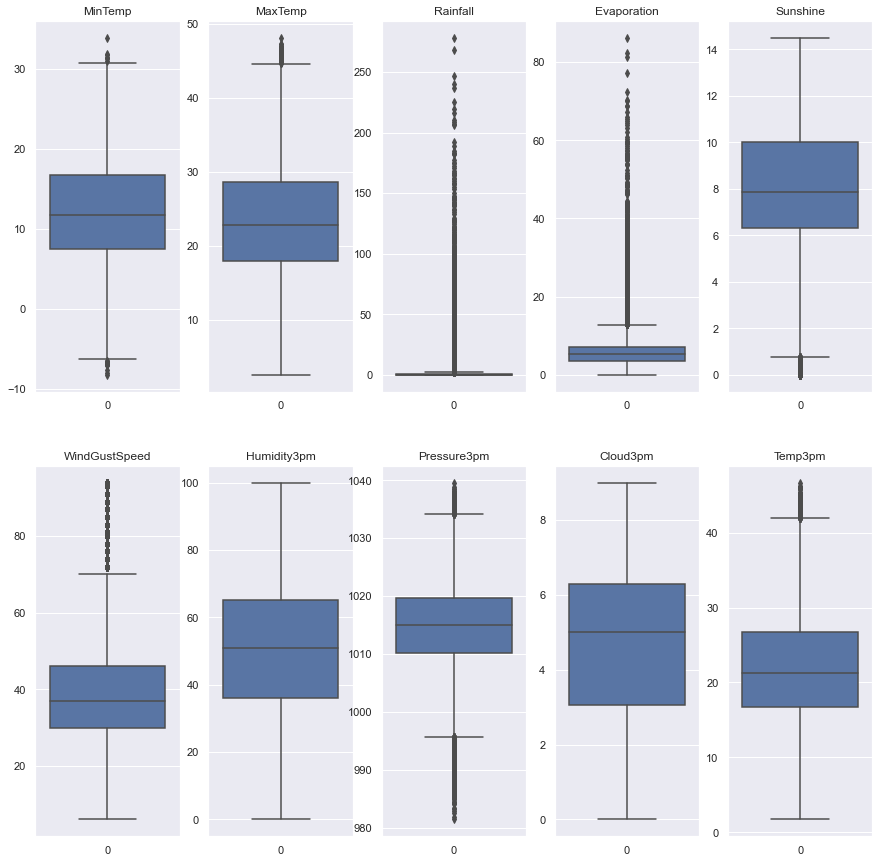

In [64]:
showBox(data)

Outliers based on the territory.

## NSW

In [65]:
checkOutliers(data[data['Territory'] == " NSW"])

MinTemp - number of extreme outliers 0
MaxTemp - number of extreme outliers 0
Rainfall - number of extreme outliers 5499
Evaporation - number of extreme outliers 180
Sunshine - number of extreme outliers 0
WindGustSpeed - number of extreme outliers 0
Humidity3pm - number of extreme outliers 0
Pressure3pm - number of extreme outliers 0
Cloud3pm - number of extreme outliers 0
Temp3pm - number of extreme outliers 0


In [66]:
df = data[data['Territory'] == " NSW"].copy()
data_NSW = removeOutliers(df, df['WindGustSpeed'])

In [67]:
checkOutliers(data_NSW)

MinTemp - number of extreme outliers 0
MaxTemp - number of extreme outliers 0
Rainfall - number of extreme outliers 5499
Evaporation - number of extreme outliers 180
Sunshine - number of extreme outliers 0
WindGustSpeed - number of extreme outliers 0
Humidity3pm - number of extreme outliers 0
Pressure3pm - number of extreme outliers 0
Cloud3pm - number of extreme outliers 0
Temp3pm - number of extreme outliers 0


Boxplots for the NSW territory

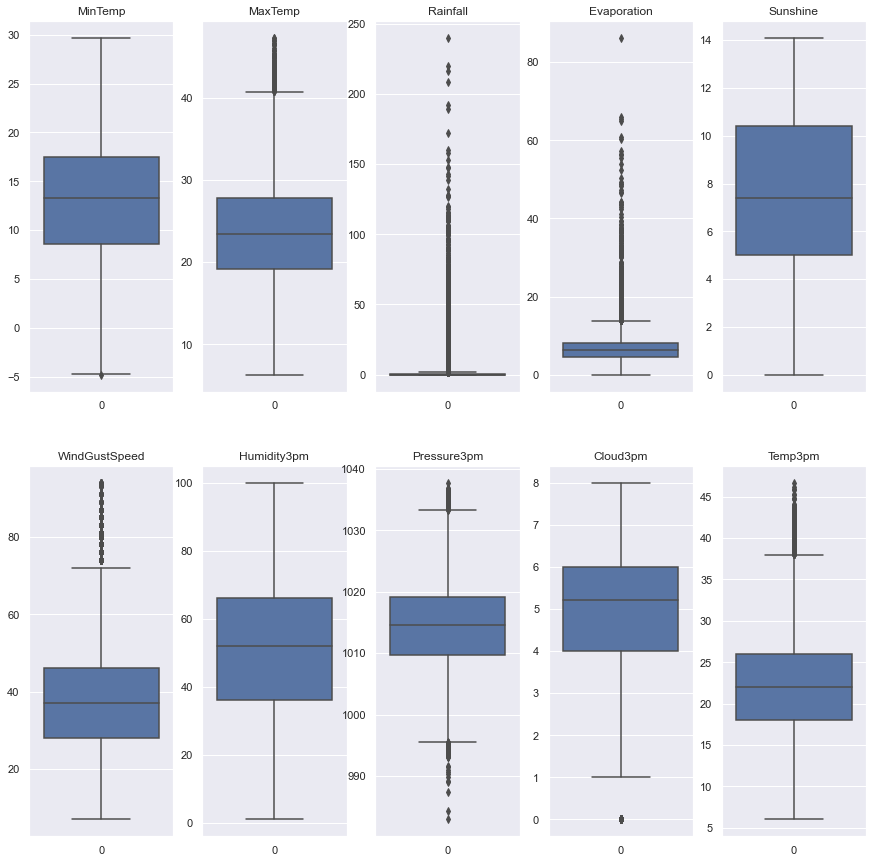

In [68]:
showBox(data_NSW)

### VIC

In [69]:
checkOutliers(data[data['Territory'] == " VIC"])

MinTemp - number of extreme outliers 0
MaxTemp - number of extreme outliers 0
Rainfall - number of extreme outliers 2305
Evaporation - number of extreme outliers 166
Sunshine - number of extreme outliers 0
WindGustSpeed - number of extreme outliers 0
Humidity3pm - number of extreme outliers 0
Pressure3pm - number of extreme outliers 0
Cloud3pm - number of extreme outliers 0
Temp3pm - number of extreme outliers 0


In [70]:
df = data[data['Territory'] == " VIC"].copy()
data_VIC = removeOutliers(df, df['WindGustSpeed'])

In [71]:
checkOutliers(data_VIC)

MinTemp - number of extreme outliers 0
MaxTemp - number of extreme outliers 0
Rainfall - number of extreme outliers 2305
Evaporation - number of extreme outliers 166
Sunshine - number of extreme outliers 0
WindGustSpeed - number of extreme outliers 0
Humidity3pm - number of extreme outliers 0
Pressure3pm - number of extreme outliers 0
Cloud3pm - number of extreme outliers 0
Temp3pm - number of extreme outliers 0


Boxplots for the VIC territory

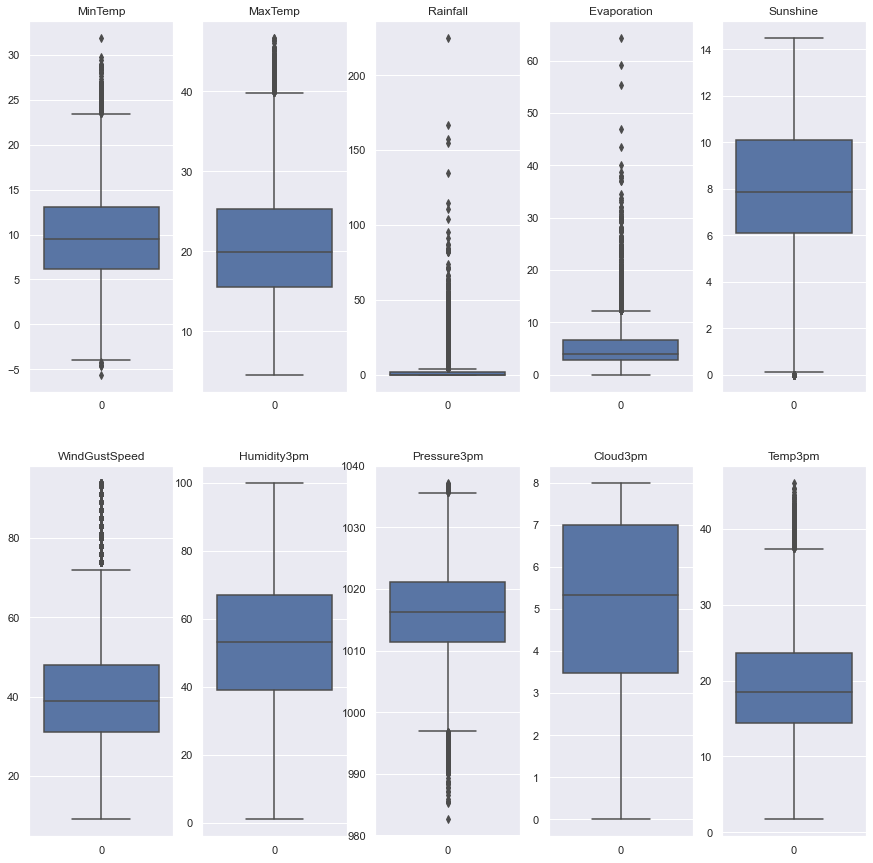

In [72]:
showBox(data_VIC)

### ACT

In [73]:
checkOutliers(data[data['Territory'] == " ACT"])

MinTemp - number of extreme outliers 0
MaxTemp - number of extreme outliers 0
Rainfall - number of extreme outliers 1309
Evaporation - number of extreme outliers 436
Sunshine - number of extreme outliers 507
WindGustSpeed - number of extreme outliers 5
Humidity3pm - number of extreme outliers 0
Pressure3pm - number of extreme outliers 0
Cloud3pm - number of extreme outliers 494
Temp3pm - number of extreme outliers 0


In [74]:
df = data[data['Territory'] == " ACT"].copy()
df = removeOutliers(df, df['WindGustSpeed'])
df = removeOutliers(df, df['Sunshine'])
df = removeOutliers(df, df['Cloud3pm'])

In [75]:
checkOutliers(df)

MinTemp - number of extreme outliers 0
MaxTemp - number of extreme outliers 0
Rainfall - number of extreme outliers 1109
Evaporation - number of extreme outliers 230
Sunshine - number of extreme outliers 16
WindGustSpeed - number of extreme outliers 0
Humidity3pm - number of extreme outliers 0
Pressure3pm - number of extreme outliers 0
Cloud3pm - number of extreme outliers 0
Temp3pm - number of extreme outliers 0


Even after removing outliers from the Sunshine attribute, some outliers remained, so I decided not to remove them.

In [76]:
df = data[data['Territory'] == " ACT"].copy()
data_ACT = removeOutliers(df, df['WindGustSpeed'])
data_ACT = removeOutliers(data_ACT, data_ACT['Cloud3pm'])

In [77]:
checkOutliers(data_ACT)

MinTemp - number of extreme outliers 0
MaxTemp - number of extreme outliers 0
Rainfall - number of extreme outliers 1230
Evaporation - number of extreme outliers 340
Sunshine - number of extreme outliers 428
WindGustSpeed - number of extreme outliers 0
Humidity3pm - number of extreme outliers 0
Pressure3pm - number of extreme outliers 0
Cloud3pm - number of extreme outliers 0
Temp3pm - number of extreme outliers 0


Boxplots for the ACT territory

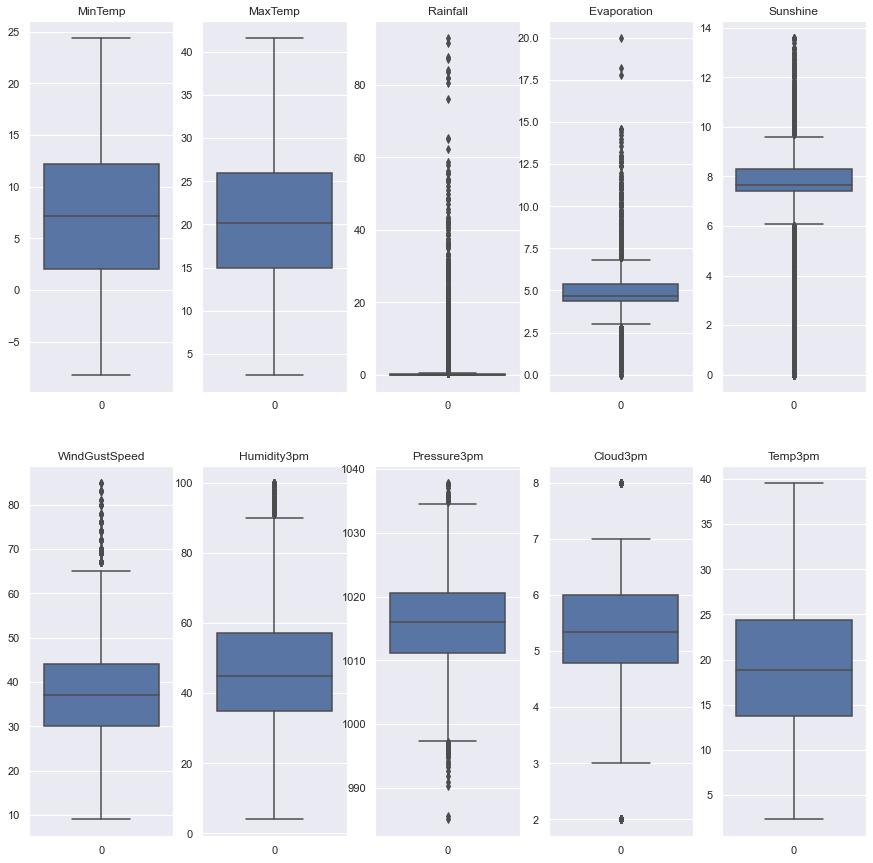

In [78]:
showBox(data_ACT)

### QLD

In [79]:
checkOutliers(data[data['Territory'] == " QLD"])

MinTemp - number of extreme outliers 0
MaxTemp - number of extreme outliers 1
Rainfall - number of extreme outliers 1412
Evaporation - number of extreme outliers 33
Sunshine - number of extreme outliers 0
WindGustSpeed - number of extreme outliers 6
Humidity3pm - number of extreme outliers 0
Pressure3pm - number of extreme outliers 0
Cloud3pm - number of extreme outliers 0
Temp3pm - number of extreme outliers 0


In [80]:
df = data[data['Territory'] == " QLD"].copy()
data_QLD = removeOutliers(df, df['WindGustSpeed'])
data_QLD = removeOutliers(data_QLD, data_QLD['MaxTemp'])

In [81]:
checkOutliers(data_QLD)

MinTemp - number of extreme outliers 0
MaxTemp - number of extreme outliers 0
Rainfall - number of extreme outliers 1409
Evaporation - number of extreme outliers 33
Sunshine - number of extreme outliers 0
WindGustSpeed - number of extreme outliers 0
Humidity3pm - number of extreme outliers 0
Pressure3pm - number of extreme outliers 0
Cloud3pm - number of extreme outliers 0
Temp3pm - number of extreme outliers 0


Boxplots for the QLD territory

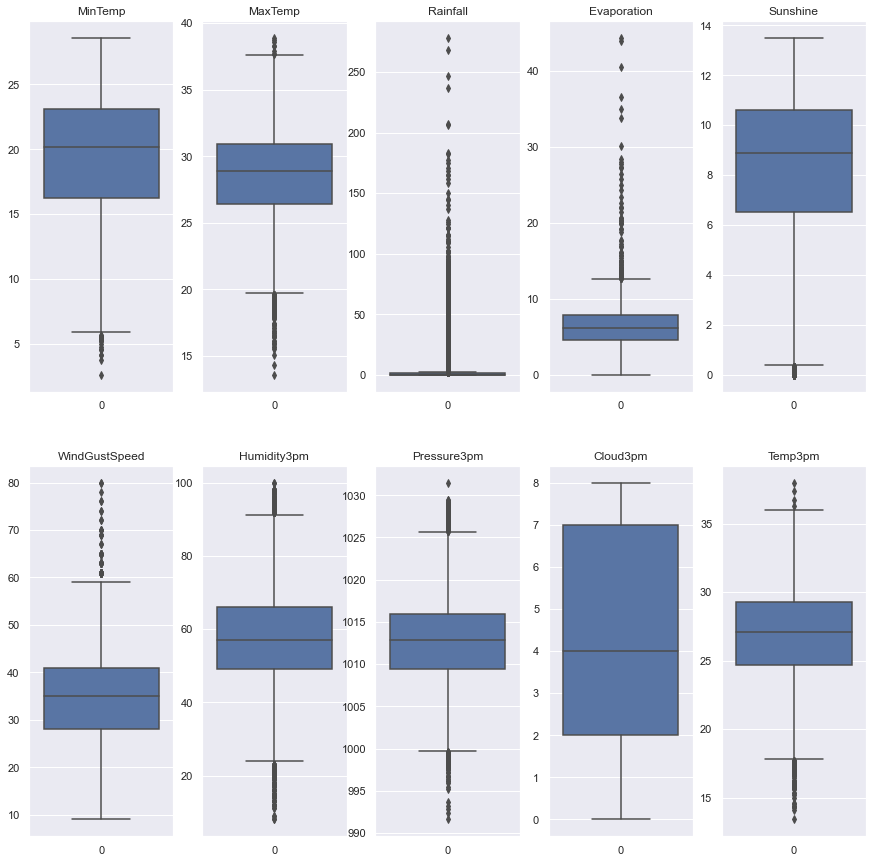

In [82]:
showBox(data_QLD)

### SA

In [83]:
checkOutliers(data[data['Territory'] == " SA"])

MinTemp - number of extreme outliers 0
MaxTemp - number of extreme outliers 0
Rainfall - number of extreme outliers 1624
Evaporation - number of extreme outliers 136
Sunshine - number of extreme outliers 0
WindGustSpeed - number of extreme outliers 0
Humidity3pm - number of extreme outliers 0
Pressure3pm - number of extreme outliers 0
Cloud3pm - number of extreme outliers 0
Temp3pm - number of extreme outliers 0


In [84]:
data_SA = data[data['Territory'] == " SA"].copy()

In [85]:
checkOutliers(data_SA)

MinTemp - number of extreme outliers 0
MaxTemp - number of extreme outliers 0
Rainfall - number of extreme outliers 1624
Evaporation - number of extreme outliers 136
Sunshine - number of extreme outliers 0
WindGustSpeed - number of extreme outliers 0
Humidity3pm - number of extreme outliers 0
Pressure3pm - number of extreme outliers 0
Cloud3pm - number of extreme outliers 0
Temp3pm - number of extreme outliers 0


Boxplots for the SA territory

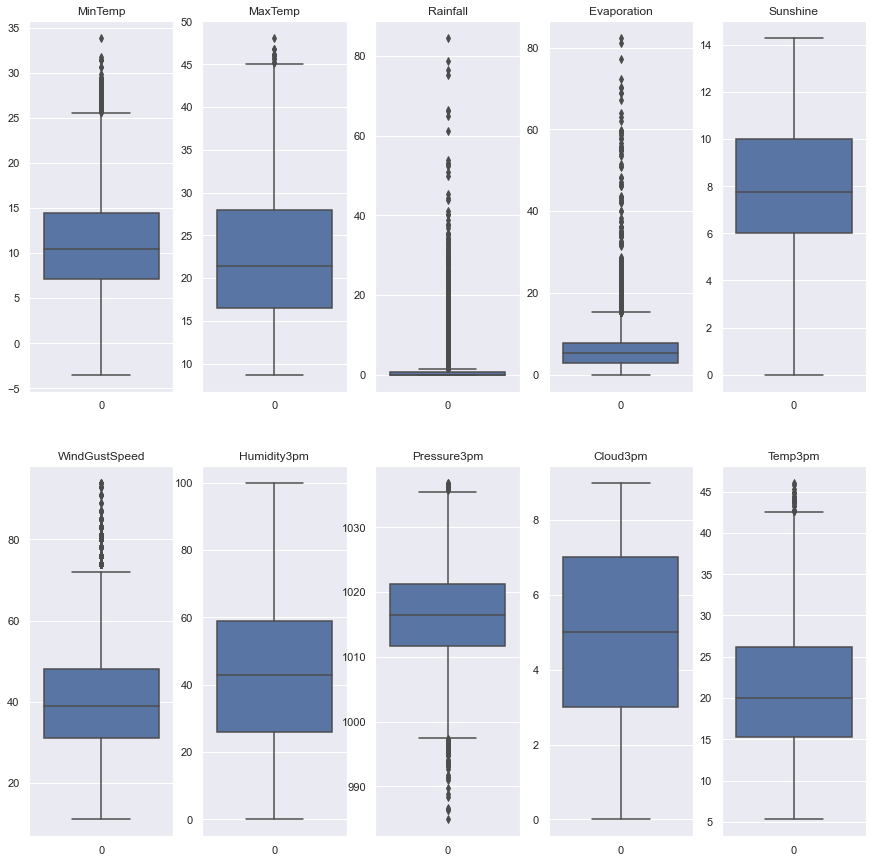

In [86]:
data_SA.index = range(len(data_SA.index))
showBox(data_SA)

### WA

In [87]:
checkOutliers(data[data['Territory'] == " WA"])

MinTemp - number of extreme outliers 0
MaxTemp - number of extreme outliers 7
Rainfall - number of extreme outliers 920
Evaporation - number of extreme outliers 432
Sunshine - number of extreme outliers 800
WindGustSpeed - number of extreme outliers 22
Humidity3pm - number of extreme outliers 0
Pressure3pm - number of extreme outliers 9
Cloud3pm - number of extreme outliers 0
Temp3pm - number of extreme outliers 22


In [88]:
df = data[data['Territory'] == " WA"].copy()
df = removeOutliers(df, df['MaxTemp'])
df = removeOutliers(df, df['WindGustSpeed'])
df = removeOutliers(df, df['Pressure3pm'])
df = removeOutliers(df, df['Temp3pm'])

In [89]:
checkOutliers(df)

MinTemp - number of extreme outliers 0
MaxTemp - number of extreme outliers 0
Rainfall - number of extreme outliers 909
Evaporation - number of extreme outliers 431
Sunshine - number of extreme outliers 799
WindGustSpeed - number of extreme outliers 0
Humidity3pm - number of extreme outliers 0
Pressure3pm - number of extreme outliers 0
Cloud3pm - number of extreme outliers 0
Temp3pm - number of extreme outliers 8


After removing outliers from the Temp3pm attribute, new ones were created, so I will not remove outliers from this attribute.

In [90]:
df = data[data['Territory'] == " WA"].copy()
data_WA = removeOutliers(df, df['MaxTemp'])
data_WA = removeOutliers(data_WA, data_WA['WindGustSpeed'])
data_WA = removeOutliers(data_WA, data_WA['Pressure3pm'])

In [91]:
checkOutliers(data_WA)

MinTemp - number of extreme outliers 0
MaxTemp - number of extreme outliers 0
Rainfall - number of extreme outliers 909
Evaporation - number of extreme outliers 431
Sunshine - number of extreme outliers 799
WindGustSpeed - number of extreme outliers 0
Humidity3pm - number of extreme outliers 0
Pressure3pm - number of extreme outliers 0
Cloud3pm - number of extreme outliers 0
Temp3pm - number of extreme outliers 15


Boxplots for the WA territory

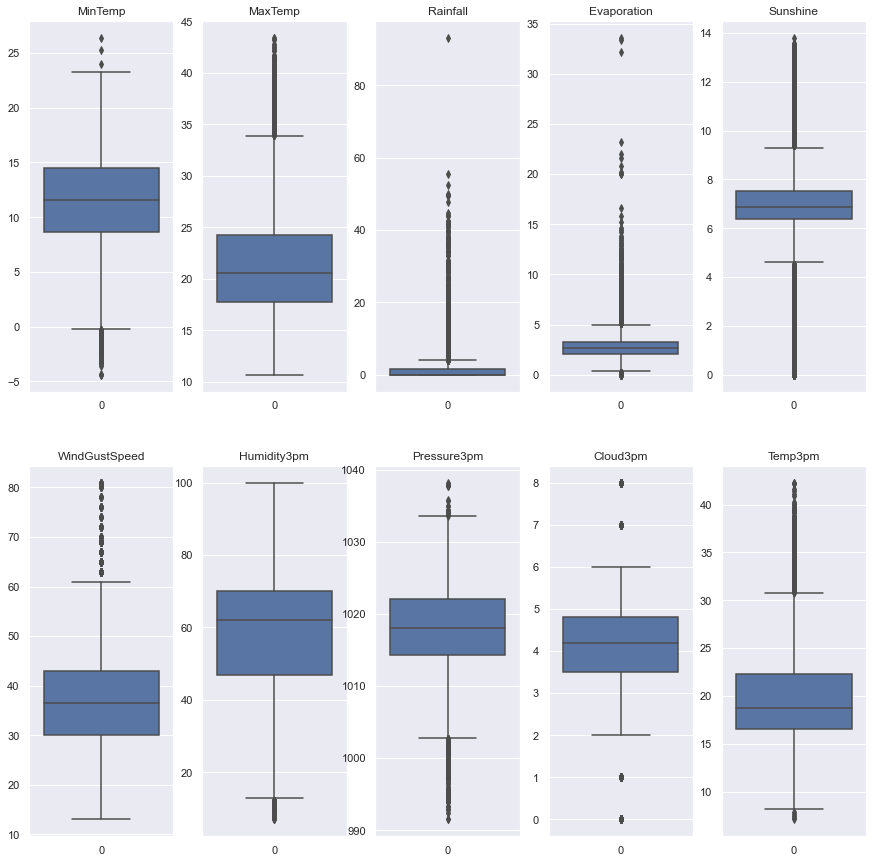

In [92]:
showBox(data_WA)

### TAS

In [93]:
checkOutliers(data[data['Territory'] == " TAS"])

MinTemp - number of extreme outliers 0
MaxTemp - number of extreme outliers 0
Rainfall - number of extreme outliers 1352
Evaporation - number of extreme outliers 13
Sunshine - number of extreme outliers 0
WindGustSpeed - number of extreme outliers 0
Humidity3pm - number of extreme outliers 0
Pressure3pm - number of extreme outliers 2
Cloud3pm - number of extreme outliers 0
Temp3pm - number of extreme outliers 0


In [94]:
df = data[data['Territory'] == " TAS"].copy()
data_TAS = removeOutliers(df, df['Pressure3pm'])

In [95]:
checkOutliers(data_TAS)

MinTemp - number of extreme outliers 0
MaxTemp - number of extreme outliers 0
Rainfall - number of extreme outliers 1351
Evaporation - number of extreme outliers 13
Sunshine - number of extreme outliers 0
WindGustSpeed - number of extreme outliers 0
Humidity3pm - number of extreme outliers 0
Pressure3pm - number of extreme outliers 0
Cloud3pm - number of extreme outliers 0
Temp3pm - number of extreme outliers 0


Boxplots for the TAS territory

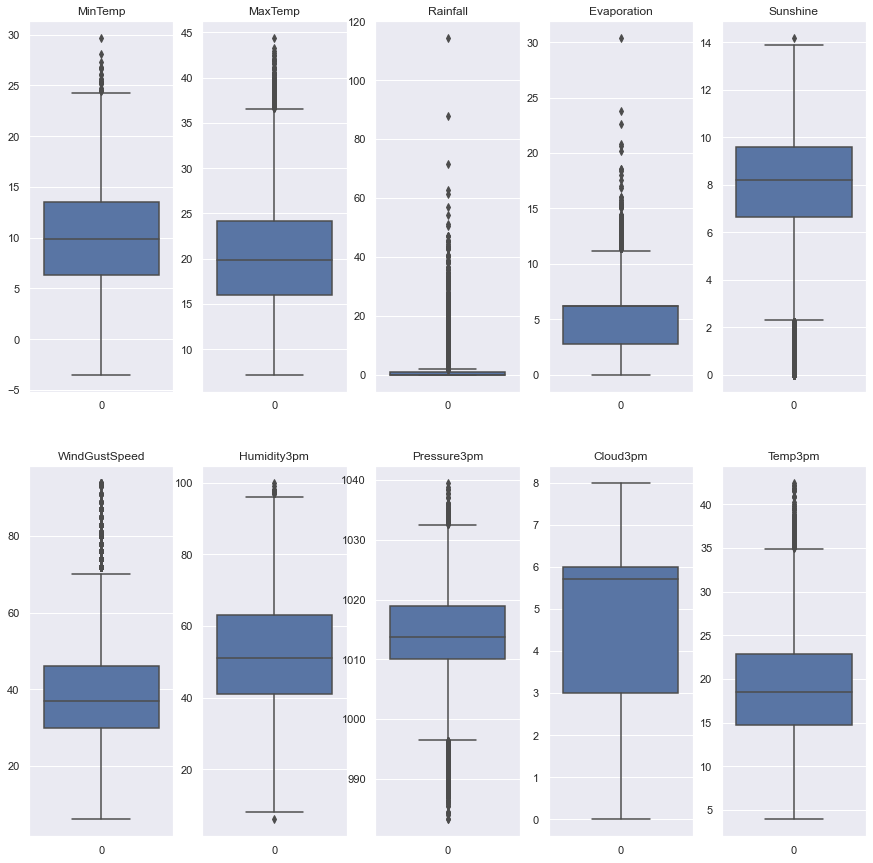

In [96]:
showBox(data_TAS)

### NT

In [97]:
checkOutliers(data[data['Territory'] == " NT"])

MinTemp - number of extreme outliers 0
MaxTemp - number of extreme outliers 19
Rainfall - number of extreme outliers 2016
Evaporation - number of extreme outliers 213
Sunshine - number of extreme outliers 376
WindGustSpeed - number of extreme outliers 16
Humidity3pm - number of extreme outliers 0
Pressure3pm - number of extreme outliers 0
Cloud3pm - number of extreme outliers 0
Temp3pm - number of extreme outliers 9


In [98]:
df = data[data['Territory'] == " NT"].copy()
data_NT = removeOutliers(df, df['MaxTemp'])
data_NT = removeOutliers(data_NT, data_NT['WindGustSpeed'])
data_NT = removeOutliers(data_NT, data_NT['Temp3pm'])

In [99]:
checkOutliers(data_NT)

MinTemp - number of extreme outliers 0
MaxTemp - number of extreme outliers 0
Rainfall - number of extreme outliers 1990
Evaporation - number of extreme outliers 212
Sunshine - number of extreme outliers 360
WindGustSpeed - number of extreme outliers 0
Humidity3pm - number of extreme outliers 0
Pressure3pm - number of extreme outliers 0
Cloud3pm - number of extreme outliers 0
Temp3pm - number of extreme outliers 0


Boxplots for the NT territory

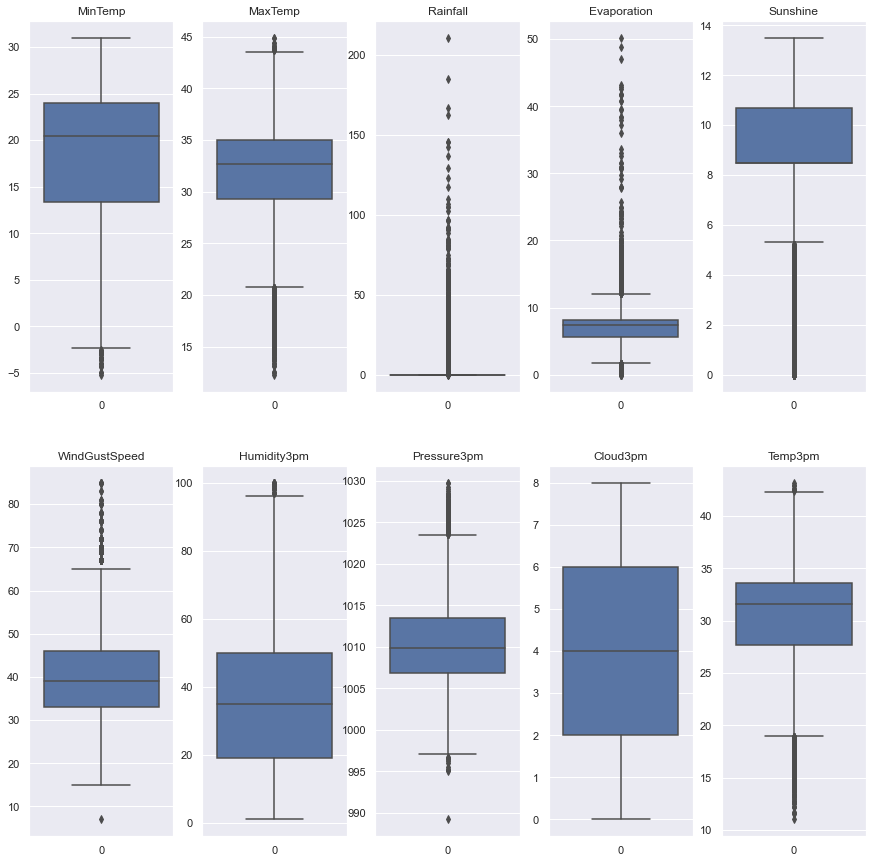

In [100]:
showBox(data_NT)

Connecting individual data from the territory into one large dataframe.

In [101]:
frames = [data_NSW, data_VIC, data_ACT, data_QLD, data_SA, data_WA, data_TAS, data_NT]
territory_data = pd.concat(frames)
territory_data.index = range(len(territory_data.index))

# Correlation <a class="anchor" id="fifth"></a>

Correlation matrix to determine individual correlations between attributes. Based on this, pair analysis and hypothesis generation follow.

In [102]:
corr = data.corr()
corr.style.background_gradient()

## Pairplot on selected attributes

Pairplot for selected attributes based on territory.

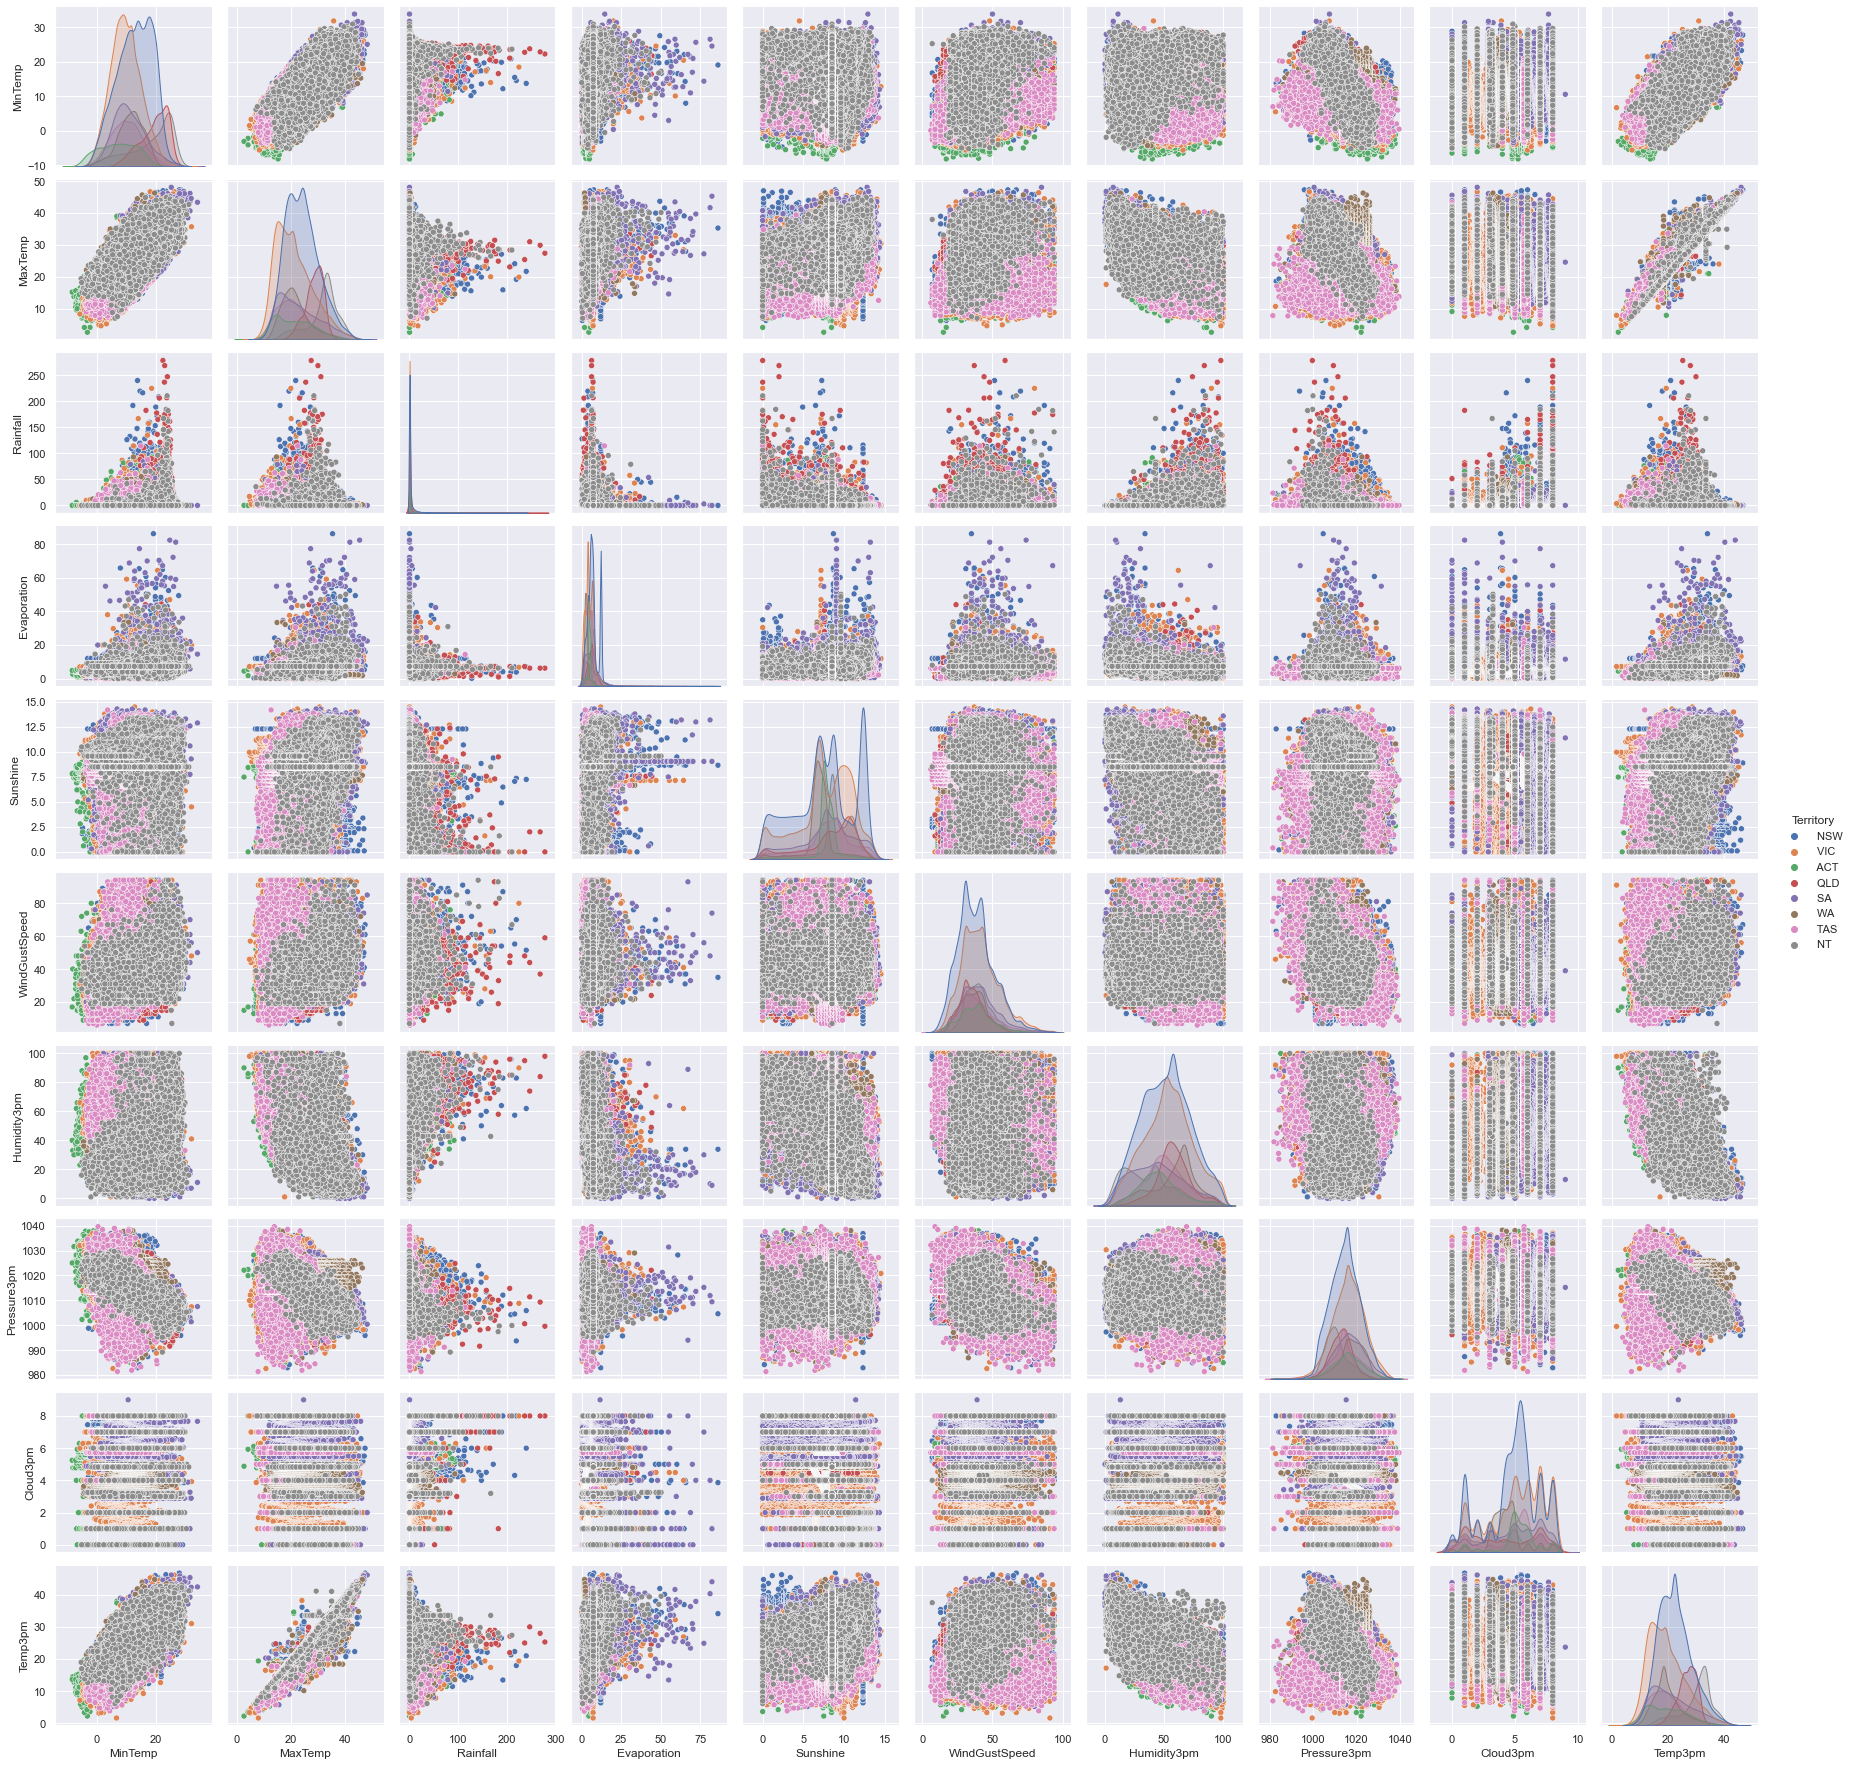

In [103]:
df = data[['Territory','MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'Humidity3pm', 'Pressure3pm', 'Cloud3pm', 'Temp3pm']].copy()
sns.pairplot(df, hue = 'Territory')

# Pair analysis of attributes <a class="anchor" id="sixth"></a>

Analysis of specific pairs, pairs were selected based on the pairplot

- MinTemp - Pressure3pm

- MaxTemp - Temp3pm

- Temp3pm - Humidity3pm

This section contains - test which distribution the data is from, most of the data is from a normal distribution, so mainly focus is on that and test whether or not it is from a normal distribution. Improve correlation if it possible and for each pair is drawn scatterplot.

Pair analysis is perform on all data, not by territory.

In [104]:
pairDf = pd.DataFrame({'A' : []}).drop("A", axis = 1)

### Pair analysis of MinTemp - Pressure3pm attributes

In [105]:
for i in range(0, 5):
    tmp = data['MinTemp'].sample(n=300)
    _, p = stats.normaltest(tmp)
    if p < 0.05: 
        print("It is not from a normal distribution", p)
    else:
        print("It is from a normal distribution", p)

It is not from a normal distribution 0.04444507826445474
It is not from a normal distribution 0.023247928428597978
It is not from a normal distribution 0.024453496958597543
It is not from a normal distribution 8.995243045862905e-05
It is from a normal distribution 0.5441683675537975


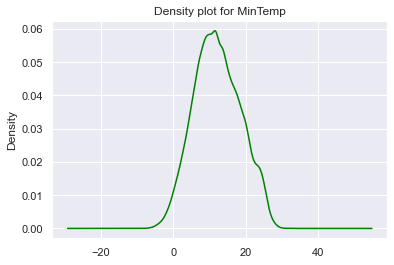

In [106]:
data.MinTemp.plot.density(color='green')
plt.title('Density plot for MinTemp')
plt.show()

MinTemp attribute more or less is from a normal distribution.

In [107]:
for i in range(0, 5):
    tmp = data['Pressure3pm'].sample(n=300)
    _, p = stats.normaltest(tmp)
    if p < 0.05: 
        print("It is not from a normal distribution", p)
    else:
        print("It is from a normal distribution", p)

It is from a normal distribution 0.1511144266289449
It is from a normal distribution 0.1607093737434452
It is from a normal distribution 0.8306180128963652
It is from a normal distribution 0.2086799518619938
It is from a normal distribution 0.3887204077373772


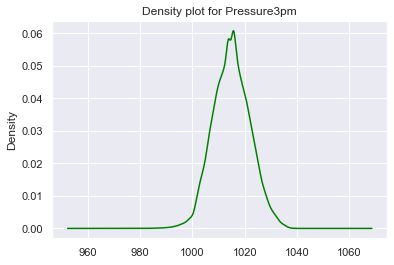

In [108]:
df.Pressure3pm.plot.density(color='green')
plt.title('Density plot for Pressure3pm')
plt.show()

We can see that the Pressure3pm attribute is from a normal distribution

After testing the distribution, we will look at their correlation and possible improvement of the mutual correlation.

In [109]:
df = data.copy()
corrDf = df.drop(['Rainfall','MaxTemp',
                  'Evaporation','Sunshine',
                  'WindGustSpeed','Humidity3pm',
                  'Cloud3pm','Temp3pm','RainToday','RainTomorrow'], axis = 1)
corr = corrDf.corr()
corr.style.background_gradient()

I will try to improve the correlation, and also test did not fully confirm that the MinTemp attribute data is from a normal distribution, so this attribute will be transform to a normal distribution.

In [110]:
quantile_transformer = preprocessing.QuantileTransformer(output_distribution='normal', random_state=0)
corrDf['MinTemp'] = quantile_transformer.fit_transform(corrDf[['MinTemp']])

In [111]:
corr = corrDf.corr()
corr.style.background_gradient()

Transformation was successful and the correlation of attributes increased slightly.

<Axes: xlabel='MinTemp', ylabel='Pressure3pm'>

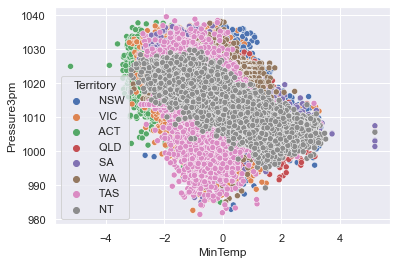

In [112]:
sns.scatterplot(corrDf['MinTemp'], corrDf['Pressure3pm'], hue=corrDf['Territory'])

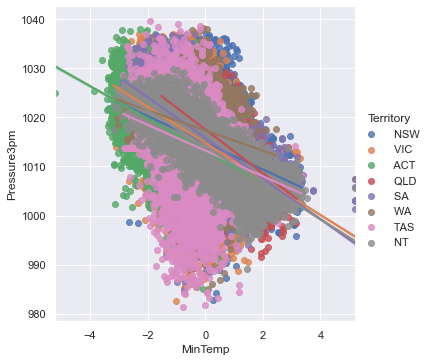

In [113]:
sns.lmplot(x="MinTemp", y="Pressure3pm", hue="Territory", data=corrDf)

In [114]:
pairDf['MinTemp'] = corrDf["MinTemp"]
pairDf['Pressure3pm'] = corrDf["Pressure3pm"]

### Pair analysis of MaxTemp - Temp3pm attributes

In [115]:
for i in range(0, 5):
    tmp = data['MaxTemp'].sample(n=300)
    _, p = stats.normaltest(tmp)
    if p < 0.05: 
        print("It is not from a normal distribution", p)
    else:
        print("It is from a normal distribution", p)

It is not from a normal distribution 0.0023769847097585674
It is not from a normal distribution 1.5729514477564068e-05
It is not from a normal distribution 0.0012660172462710733
It is not from a normal distribution 0.001274201036927886
It is not from a normal distribution 0.004115283528277235


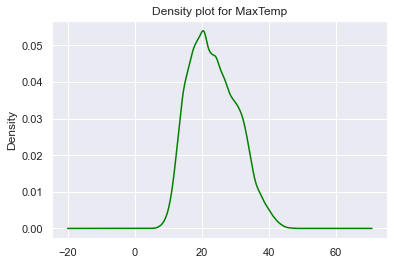

In [116]:
df.MaxTemp.plot.density(color='green')
plt.title('Density plot for MaxTemp')
plt.show()

We can see from the graph that the distribution of the data should be from a normal distribution, but the test did not confirm this.

In [117]:
for i in range(0, 5):
    tmp = data['Temp3pm'].sample(n=300)
    _, p = stats.normaltest(tmp)
    if p < 0.05: 
        print("It is not from a normal distribution", p)
    else:
        print("It is from a normal distribution", p)

It is not from a normal distribution 0.0367399646920537
It is not from a normal distribution 4.888806390936686e-06
It is not from a normal distribution 1.0517233008277062e-05
It is not from a normal distribution 0.0061146107381254
It is not from a normal distribution 0.000678014601182822


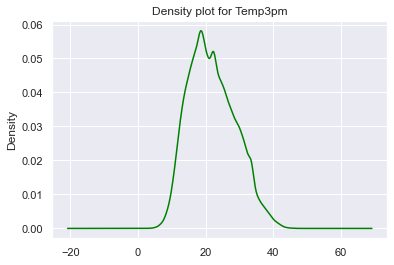

In [118]:
df.Temp3pm.plot.density(color='green')
plt.title('Density plot for Temp3pm')
plt.show()

We can also see in the second graph that it should be from a normal distribution, but the test did not confirm it.

In [119]:
df = data.copy()
corrDf = df.drop(['MinTemp','Sunshine',
                  'Humidity3pm','Rainfall',
                  'WindGustSpeed','Pressure3pm',
                  'Cloud3pm','Evaporation','RainToday','RainTomorrow'], axis = 1)

corr = corrDf.corr()
corr.style.background_gradient()

For this correlation, the data will not be transformed because the correlation matrix shows a very high correlation.

<Axes: xlabel='MaxTemp', ylabel='Temp3pm'>

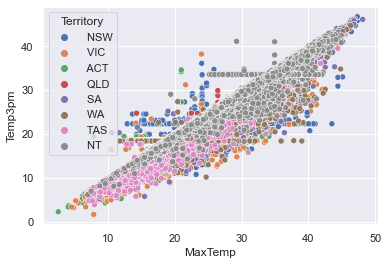

In [120]:
sns.scatterplot(corrDf['MaxTemp'], corrDf['Temp3pm'], hue=data['Territory'])

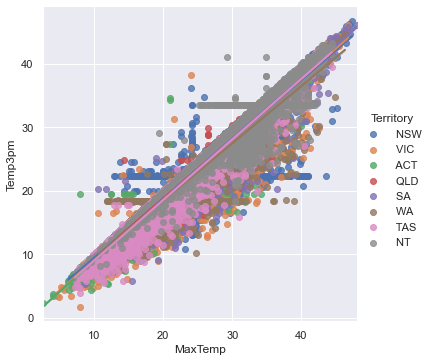

In [121]:
sns.lmplot(x="MaxTemp", y="Temp3pm", hue="Territory", data=corrDf)

In [122]:
pairDf["MaxTemp"] = corrDf["MaxTemp"]
pairDf["Temp3pm"] = corrDf["Temp3pm"]

### Pair analysis of Temp3pm - Humidity3pm attributes

In [123]:
for i in range(0, 5):
    tmp = data['Temp3pm'].sample(n=300)
    _, p = stats.normaltest(tmp)
    if p < 0.05: 
        print("It is not from a normal distribution", p)
    else:
        print("It is from a normal distribution", p)

It is not from a normal distribution 0.01240043426957682
It is not from a normal distribution 0.0012835338993957644
It is not from a normal distribution 0.0013795181867119347
It is not from a normal distribution 0.0009225879930231073
It is not from a normal distribution 0.001025241195881095


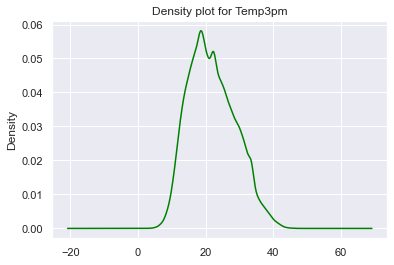

In [124]:
df.Temp3pm.plot.density(color='green')
plt.title('Density plot for Temp3pm')
plt.show()

We can see that the data is not from a normal distribution, although if we look at the graph we could say that the data is from a normal distribution.

In [125]:
for i in range(0, 5):
    tmp = data['Humidity3pm'].sample(n=300)
    _, p = stats.normaltest(tmp)
    if p < 0.05: 
        print("It is not from a normal distribution", p)
    else:
        print("It is from a normal distribution", p)

It is not from a normal distribution 0.008112003283919964
It is not from a normal distribution 0.04771823582260445
It is not from a normal distribution 0.0003415290728330168
It is not from a normal distribution 0.00748201184710486
It is not from a normal distribution 0.015931370983840565


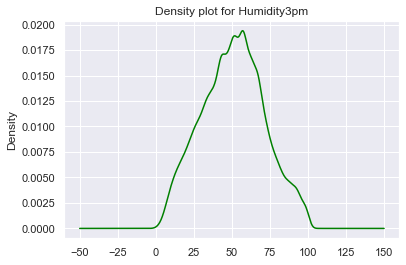

In [126]:
df.Humidity3pm.plot.density(color='green')
plt.title('Density plot for Humidity3pm')
plt.show()

We can see that the data is not from a normal distribution but graph looks like from normal distribution.

In [127]:
df = data.copy()
corrDf = df.drop(['MinTemp','MaxTemp',
                  'WindGustSpeed','Rainfall',
                  'Evaporation','Pressure3pm',
                  'Sunshine','Cloud3pm','RainToday','RainTomorrow'], axis = 1)

corr = corrDf.corr()
corr.style.background_gradient()

Since the test did not confirm that the attribute Temp3pm is from a normal distribution, this attribute will be transformed to a normal distribution.

In [128]:
quantile_transformer = preprocessing.QuantileTransformer(output_distribution='normal', random_state=0)
corrDf['Temp3pm'] = quantile_transformer.fit_transform(corrDf[['Temp3pm']])

In [129]:
corr = corrDf.corr()
corr.style.background_gradient()

We can see a slight improvement on the correlation matrix after the transformation.

<Axes: xlabel='Humidity3pm', ylabel='Temp3pm'>

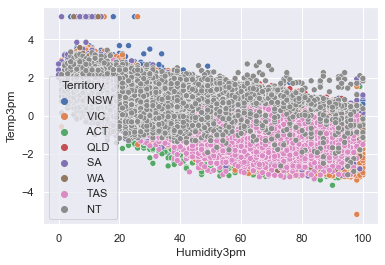

In [130]:
sns.scatterplot(corrDf['Humidity3pm'], corrDf['Temp3pm'], hue=data['Territory'])

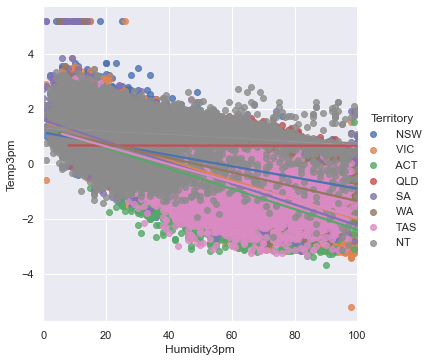

In [131]:
sns.lmplot(x="Humidity3pm", y="Temp3pm", hue="Territory", data=corrDf)

In [132]:
pairDf["Humidity3pm"] = corrDf["Humidity3pm"]

# Hypotheses <a class="anchor" id="seventh"></a>

After pair analysis of attributes is followed by hypotheses. Each hypothesis is tested using two approaches, using the stats.linregress statistical library and using a trained Linear Regression model.

### Hypothesis 1

- When the temperature drops, the air pressure raises (MinTemp - Pressure3pm)

### Hypothesis 2

- The afternoon was the warmest (MaxTemp - Temp3pm)

### Hypothesis 3

- When the temperature drops, the air humidity increases (Temp3pm - Humidity3pm)



## Hypothesis 1
- When the temperature drops, the air pressure raises (MinTemp - Pressure3pm)

For this hypothesis, the trained model performed slightly better in terms of R-Squared value, but both methods only cover about 20% of the data.

This hypothesis can be confirmed, but both models capture a small percentage of the data

Slope -0.06452168858152114
Intercept 65.48233611512849
Stderr 0.00036546598617414363
R-squared: 0.20468284861771874


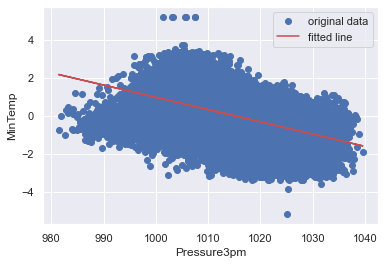

In [133]:
x = pairDf['Pressure3pm']
y = pairDf['MinTemp']

result = stats.linregress(x, y)
    
print("Slope", result.slope)
print("Intercept", result.intercept)
print("Stderr", result.stderr)
print("R-squared:", result.rvalue**2)

plt.plot(x, y, 'o', label='original data')
plt.plot(x, result.intercept + result.slope*x, 'r', label='fitted line')
plt.legend()
plt.xlabel("Pressure3pm")
plt.ylabel("MinTemp")
plt.show()

Slope: [-0.06477941]
Intercept: 65.74288731257236
R-squared: 0.20542236397019342


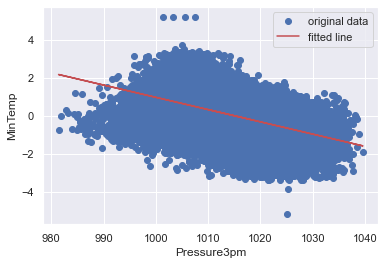

In [134]:
for i in range(0, 1):
    tmp1 = pairDf['Pressure3pm']
    tmp1 = tmp1.values.reshape(-1,1)
    tmp2 = pairDf['MinTemp']
    
    X_train, X_test, y_train, y_test = train_test_split(tmp1, tmp2, test_size=0.3, random_state=1)
    model = LinearRegression()
    model.fit(X_train, y_train)
    r_sq = model.score(X_train, y_train)
    print('Slope:', model.coef_)
    print('Intercept:', model.intercept_)
    print('R-squared:', r_sq)
    
    plt.plot(X_train, y_train, 'o', label='original data')
    plt.plot(X_train, result.intercept + result.slope*X_train, 'r', label='fitted line')
    plt.legend()
    plt.xlabel("Pressure3pm")
    plt.ylabel("MinTemp")
    plt.show()
    print("\n")

## Hypothesis 2
- The afternoon was the warmest (MaxTemp - Temp3pm)

The trained model shows the same success in R-Squared as the functions from statistical libraries, both methods cover about 96% of the data, which is very good.

This hypothesis is confirmed.

Slope 0.9577690289041061
Intercept -0.5036091600573478
Stderr 0.0005492704293315586
R-squared: 0.9616942222822404


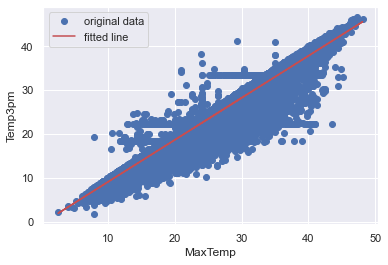

In [135]:
x = pairDf['MaxTemp']
y = pairDf['Temp3pm']

result = stats.linregress(x, y)
    
print("Slope", result.slope)
print("Intercept", result.intercept)
print("Stderr", result.stderr)
print("R-squared:", result.rvalue**2)

plt.plot(x, y, 'o', label='original data')
plt.plot(x, result.intercept + result.slope*x, 'r', label='fitted line')
plt.legend()
plt.xlabel("MaxTemp")
plt.ylabel("Temp3pm")
plt.show()

Slope: [0.95793802]
Intercept: -0.5084839723734902
R-squared: 0.961928436354074


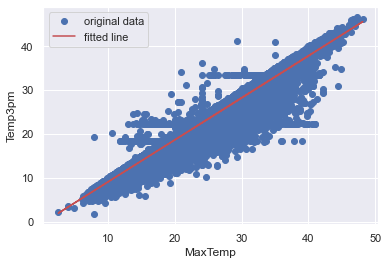

In [136]:
for i in range(0, 1):
    tmp1 = pairDf['MaxTemp']
    tmp1 = tmp1.values.reshape(-1,1)
    tmp2 = pairDf['Temp3pm']
    
    X_train, X_test, y_train, y_test = train_test_split(tmp1, tmp2, test_size=0.3, random_state=1)
    model = LinearRegression()
    model.fit(X_train, y_train)
    r_sq = model.score(X_train, y_train)
    print('Slope:', model.coef_)
    print('Intercept:', model.intercept_)
    print('R-squared:', r_sq)
    
    plt.plot(X_train, y_train, 'o', label='original data')
    plt.plot(X_train, result.intercept + result.slope*X_train, 'r', label='fitted line')
    plt.legend()
    plt.xlabel("MaxTemp")
    plt.ylabel("Temp3pm")
    plt.show()
    print("\n")
    

## Hypothesis 3
- When the temperature drops, the air humidity increases (Temp3pm - Humidity3pm)

The trained model and functions from the statistics library, the stats.linregress function, both covers 30% of the data.

This hypothesis can be confirmed, but both models lacked data.

Slope -0.18435259792083986
Intercept 31.316461306333963
Stderr 0.0008026706885445856
R-squared: 0.30340739312288156


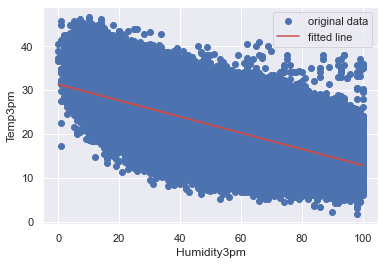

In [137]:
x = pairDf['Humidity3pm']
y = pairDf['Temp3pm']

result = stats.linregress(x, y)
    
print("Slope", result.slope)
print("Intercept", result.intercept)
print("Stderr", result.stderr)
print("R-squared:", result.rvalue**2)

plt.plot(x, y, 'o', label='original data')
plt.plot(x, result.intercept + result.slope*x, 'r', label='fitted line')
plt.legend()
plt.xlabel("Humidity3pm")
plt.ylabel("Temp3pm")
plt.show()

Slope: [-0.18358101]
Intercept: 31.272145385675223
R-squared: 0.301472397478018


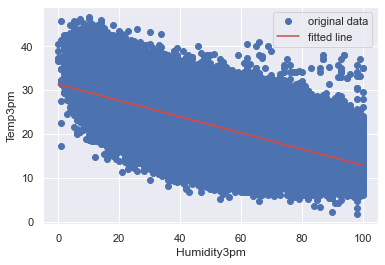

In [138]:
for i in range(0, 1):
    tmp1 = pairDf['Humidity3pm']
    tmp1 = tmp1.values.reshape(-1,1)
    tmp2 = pairDf['Temp3pm']
    
    X_train, X_test, y_train, y_test = train_test_split(tmp1, tmp2, test_size=0.3, random_state=1)
    model = LinearRegression()
    model.fit(X_train, y_train)
    r_sq = model.score(X_train, y_train)
    print('Slope:', model.coef_)
    print('Intercept:', model.intercept_)
    print('R-squared:', r_sq)
    
    plt.plot(X_train, y_train, 'o', label='original data')
    plt.plot(X_train, result.intercept + result.slope*X_train, 'r', label='fitted line')
    plt.legend()
    plt.xlabel("Humidity3pm")
    plt.ylabel("Temp3pm")
    plt.show()
    print("\n")

# Prediction <a class="anchor" id="eigth"></a>

Through the attributes it is possible to predict whether it will rain tomorrow or not, it can be verified using the attribute RainTomorrow.

The probabilityRainTomorrow function is calculated using the Logistic Regression model and determines the success of this model.

Predictions are for individual territories.

In [139]:
propabilityRainTomorrow(territory_data)

Probability for territory  NSW
              precision    recall  f1-score   support

           0       0.96      0.87      0.91      6399
           1       0.44      0.75      0.55       901

    accuracy                           0.85      7300
   macro avg       0.70      0.81      0.73      7300
weighted avg       0.90      0.85      0.87      7300

Consufion matrix
 [[5541  858]
 [ 226  675]] 

The success of predicting that it will rain tomorrow is 85.0 %



Probability for territory  VIC
              precision    recall  f1-score   support

           0       0.95      0.86      0.90      4919
           1       0.46      0.71      0.56       850

    accuracy                           0.84      5769
   macro avg       0.70      0.79      0.73      5769
weighted avg       0.87      0.84      0.85      5769

Consufion matrix
 [[4215  704]
 [ 243  607]] 

The success of predicting that it will rain tomorrow is 84.0 %



Probability for territory  ACT
              precision    

# Bayes <a class="anchor" id="nineth"></a>

Training a Bayesian model that can predict the weather for individual territories, the RainToday attribute helps, which tells whether it rained on the given day or not.

Attributes on which is model trained

* Sunshine

* Cloud3pm

* Pressure3pm

* Humidity3pm

* RainToday - on the basis of which it is possible to determine the predicted success

* Territory - in which territories it is possible to determine the forecast

Attributes and how they are modified

The Sunshine attribute has values ​​from 0 to 14.5, this attribute is modified as follows
* ​​from 0 to 4.9, assigned a value 0
* ​​from 5 to 9.9, assigned a value 5
* ​​from 10 to 15, assigned a value 10

The Cloud3pm attribute has values ​​from 0 to 9, this attribute is modified as follows
* ​​from 0 to 1.9, assigned a value 0
* ​​from 2 to 3.9, assigned a value 2
* ​​from 4 to 5.9, assigned a value 4
* equal or higher than 6, assigned a value 6

The Pressure3pm attribute has values ​​from 977.1 to 1039.6, this attribute is modified as follows
* ​​from 970 to 999.9, assigned a value 0
* ​​from 1000 to 1099.9, assigned a value 1

The Humidity3pm attribute has values ​​from 0 to 100, this attribute is modified as follows
* ​​from 0 to 19.9, assigned a value 0
* ​​from 20 to 39.9, assigned a value 20
* ​​from 40 to 59.9, assigned a value 40
* ​​from 60 to 79.9, assigned a value 60
* ​​from 80 to 100, assigned a value 80


Atribut RainToday obsahuje hodnoty
* 0 it didn't rain that day
* 1 it rained that day

In [140]:
data_b = territory_data.copy()

In [141]:
data_b['Sunshine'] = list(map(lambda x: changeSun(x), data_b['Sunshine']))
data_b['Sunshine'] = data_b['Sunshine'].astype(int)

In [142]:
data_b['Cloud3pm'] = list(map(lambda x: changeCloud(x), data_b['Cloud3pm']))
data_b['Cloud3pm'] = data_b['Cloud3pm'].astype(int)

In [143]:
data_b['Pressure3pm'] = list(map(lambda x: changePressure(x), data_b['Pressure3pm']))

In [144]:
data_b['Humidity3pm'] = list(map(lambda x: changeHumidity(x), data_b['Humidity3pm']))
data_b['Humidity3pm'] = data_b['Humidity3pm'].astype(int)

In [145]:
data_b.head()

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  01/12/2008   Albury     13.4     22.9       0.6         12.0        10   
1  02/12/2008   Albury      7.4     25.1       0.0         12.0        10   
2  03/12/2008   Albury     12.9     25.7       0.0         12.0        10   
3  04/12/2008   Albury      9.2     28.0       0.0         12.0        10   
4  05/12/2008   Albury     17.5     32.3       1.0         12.0        10   

   WindGustSpeed  Humidity3pm  Pressure3pm  Cloud3pm  Temp3pm  RainToday  \
0           44.0           20            1         4     21.8          0   
1           44.0           20            1         4     24.3          0   
2           46.0           20            1         2     23.2          0   
3           24.0            0            1         4     26.5          0   
4           41.0           20            1         6     29.7          0   

   RainTomorrow Territory  
0             0       NSW  
1             0       NSW  
2             0       NSW  
3             0       NSW  
4             0       NSW

Removing attributes that are not interesting

In [146]:
data_b = data_b.drop(['Date', 'Location',
                      'MinTemp', 'MaxTemp',
                      'Rainfall', 'Evaporation',
                      'WindGustSpeed', 'Temp3pm', 'RainTomorrow'], axis = 1)

In [147]:
data_b.head()

Sunshine  Humidity3pm  Pressure3pm  Cloud3pm  RainToday Territory
0        10           20            1         4          0       NSW
1        10           20            1         4          0       NSW
2        10           20            1         2          0       NSW
3        10            0            1         4          0       NSW
4        10           20            1         6          0       NSW

The example below shows how individual attributes are modified

In [148]:
np.unique(data_b['Sunshine'])

array([ 0,  5, 10])

In [149]:
np.unique(data_b['Humidity3pm'])

array([ 0, 20, 40, 60, 80])

In [150]:
np.unique(data_b['Pressure3pm'])

array([0, 1], dtype=int64)

In [151]:
np.unique(data_b['Cloud3pm'])

array([0, 2, 4, 6])

In [152]:
np.unique(data_b['RainToday'])

array([0, 1], dtype=int64)

Individual territories

In [153]:
np.unique(data_b['Territory'])

array([' ACT', ' NSW', ' NT', ' QLD', ' SA', ' TAS', ' VIC', ' WA'],
      dtype=object)

Territory  ACT
Data:
       Sunshine  Humidity3pm  Pressure3pm  Cloud3pm  RainToday
65341         5           20            1         6          0
65342         5           20            1         2          1
65343         0           60            1         6          1
65344         5           40            1         6          1
65345        10           40            1         6          1
...         ...          ...          ...       ...        ...
71307         5           20            1         6          0
71308         5           40            1         6          0
71309         5           20            1         6          0
71310         5           40            1         6          0
71311         5           40            1         6          0

[5971 rows x 5 columns]
Confusion matrix
[[942  21]
 [209  23]]


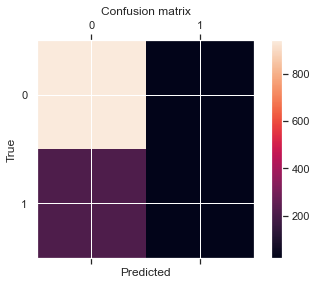

The success of weather forecasting is  80.75 %


Territory  NSW
Data:
       Sunshine  Humidity3pm  Pressure3pm  Cloud3pm  RainToday
0            10           20            1         4          0
1            10           20            1         4          0
2            10           20            1         2          0
3            10            0            1         4          0
4            10           20            1         6          0
...         ...          ...          ...       ...        ...
36492         5           60            1         4          0
36493         5           60            1         4          0
36494         5           40            1         6          0
36495         5           20            1         4          0
36496         5           20            1         4          0

[36497 rows x 5 columns]
Confusion matrix
[[5521  231]
 [1267  281]]


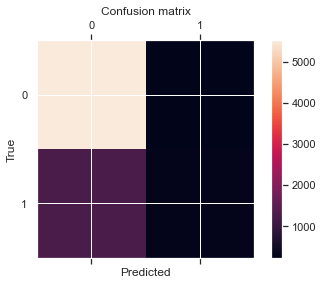

The success of weather forecasting is  79.48 %


Territory  NT
Data:
        Sunshine  Humidity3pm  Pressure3pm  Cloud3pm  RainToday
111190        10            0            1         4          1
111191        10            0            1         2          0
111192         5           20            1         6          0
111193         0           40            1         6          0
111194         0           60            1         6          1
...          ...          ...          ...       ...        ...
120528         5           20            1         4          0
120529         5           20            1         4          0
120530         5           20            1         4          0
120531         5           20            1         2          0
120532         5           20            1         6          0

[9343 rows x 5 columns]
Confusion matrix
[[1499   97]
 [ 133  140]]


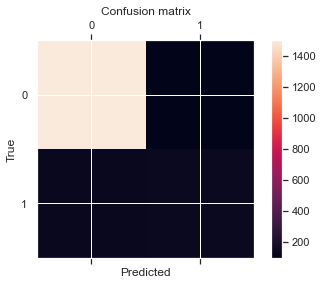

The success of weather forecasting is  87.69 %


Territory  QLD
Data:
       Sunshine  Humidity3pm  Pressure3pm  Cloud3pm  RainToday
71312         5           20            1         0          0
71313         5           20            1         0          0
71314         5           40            1         4          0
71315         0           40            1         6          0
71316         0           80            1         6          0
...         ...          ...          ...       ...        ...
80570         5           40            1         4          0
80571         5           40            1         4          0
80572         5           40            1         6          0
80573         5           40            1         6          0
80574         5           40            1         6          0

[9263 rows x 5 columns]
Confusion matrix
[[1302  130]
 [ 240  181]]


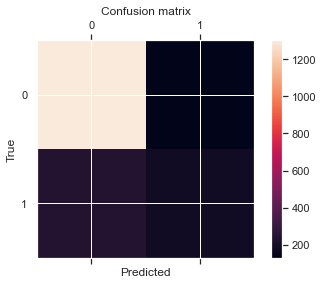

The success of weather forecasting is  80.03 %


Territory  SA
Data:
       Sunshine  Humidity3pm  Pressure3pm  Cloud3pm  RainToday
80575         0           60            1         6          1
80576         5           40            1         6          0
80577         0           40            1         6          0
80578         5           40            1         6          0
80579         0           60            1         6          0
...         ...          ...          ...       ...        ...
92801         5           20            1         2          0
92802         5           20            1         6          0
92803         5           20            1         2          0
92804         5           20            1         2          0
92805         5           40            1         2          0

[12231 rows x 5 columns]
Confusion matrix
[[1794  202]
 [ 295  156]]


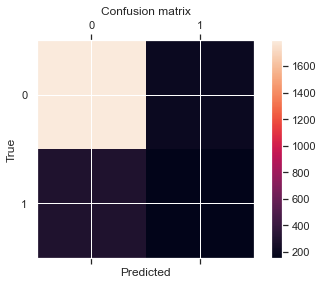

The success of weather forecasting is  79.69 %


Territory  TAS
Data:
        Sunshine  Humidity3pm  Pressure3pm  Cloud3pm  RainToday
101816         5           40            1         2          0
101817         5           20            1         6          0
101818         5           60            1         2          0
101819         0           60            1         6          1
101820         0           40            1         4          1
...          ...          ...          ...       ...        ...
111185         5           40            1         4          1
111186         5           60            1         6          0
111187         5           80            1         6          1
111188         5           40            1         6          1
111189         5           60            1         6          0

[9374 rows x 5 columns]
Confusion matrix
[[1403   61]
 [ 333   78]]


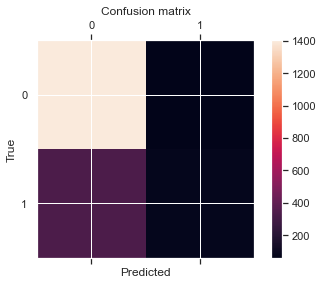

The success of weather forecasting is  78.99 %


Territory  VIC
Data:
       Sunshine  Humidity3pm  Pressure3pm  Cloud3pm  RainToday
36497         5           20            1         6          0
36498         5           40            1         2          0
36499         0           40            1         6          0
36500        10           40            1         0          0
36501        10           20            1         2          0
...         ...          ...          ...       ...        ...
65336         5           80            1         0          0
65337         5           60            1         0          0
65338         5           80            1         0          0
65339         5           60            1         0          1
65340         5           80            1         0          0

[28844 rows x 5 columns]
Confusion matrix
[[4282  170]
 [1151  166]]


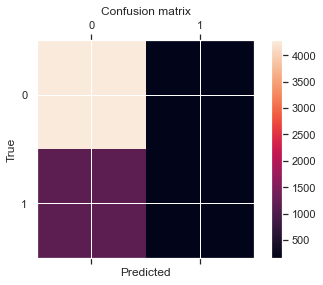

The success of weather forecasting is  77.1 %


Territory  WA
Data:
        Sunshine  Humidity3pm  Pressure3pm  Cloud3pm  RainToday
92806          5           60            1         4          0
92807          5           60            1         6          0
92808         10           60            0         6          0
92809          5           80            1         6          1
92810          0           60            1         4          0
...          ...          ...          ...       ...        ...
101811         5           40            1         4          0
101812         5           80            1         4          0
101813         5           60            1         4          1
101814         5           60            1         4          1
101815         5           60            1         4          1

[9010 rows x 5 columns]
Confusion matrix
[[1285   55]
 [ 418   44]]


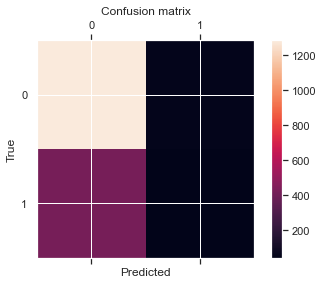

The success of weather forecasting is  73.75 %




In [154]:
unique_territory = np.unique(data_b['Territory'])

for i in unique_territory:
    data1 = data_b[data_b['Territory'] == i]
    data1 = data1.drop(['Territory'], axis = 1)
    print("Territory", i)
    print("Data:")
    print(data1)
    
    x = data1.iloc[:, [0, 1, 2, 3]].values
    y = data1.iloc[:, -1].values
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 0)

    classifier = GaussianNB()
    classifier.fit(x_train, y_train)
    
    y_pred =  classifier.predict(x_test)
    print("Confusion matrix")
    
    labels = ['0', '1']
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    print("The success of weather forecasting is ", round(accuracy_score(y_test, y_pred)*100, 2),"%")
    print("\n")

The best result using Byesian model for weather forecasting is for territory NT - 87.69 %